
- Cover: Problem → Data → Baselines → Advanced model → Training → Results → Ablations → Stress test → Ultimate judgment → How to run on AWS.


In [63]:
!pip install --upgrade "tensorflow[and-cuda]==2.19.1" "keras==3.6.0" "ml-dtypes==0.5.1" keras-hub --only-binary=:all: -q

# <div align="center"> <font>Bridging Language and Vision: Deep Learning for Entailment Prediction (Visual Entailment)</font></div>

## Introduction
This project is organised into two stages: the baseline task builds a multimodal model for visual–textual entailment, and the enhancement task strengthens cross-modal reasoning with cross-attention. The goal is to decide whether a hypothesis sentence is entailed or contradicted by a premise image, without using any premise sentence as input.

In the baseline, visual features are obtained from EfficientNetB0 and textual embeddings from a BERT backbone. We adopt a staged training procedure: (1) initialise with both backbones frozen to stabilise fusion; (2) selectively unfreeze the top ~30% of EfficientNet layers (while keeping BatchNorm frozen) and the last N transformer blocks of BERT; and (3) fine-tune with a low learning rate. The fused representation uses simple concatenation followed by a compact MLP and a sigmoid classifier for binary entailment vs. contradiction.

In the enhancement stage, we introduce a cross-attention module that allows token-level BERT representations to attend to spatial image features, enabling finer alignment between entities and visual regions. This replaces naïve concatenation with learned interactions, aiming to reduce failure cases where simple fusion cannot capture subtle visual–textual correspondences.

By combining robust pretrained encoders with controlled unfreezing and advancing from concat fusion to cross-attention, the project delivers a practical and extensible framework for visual–textual entailment under the constraint of image-only premises.

### Importing Libraries and Setting up environment 

In [64]:
# === 0. Imports, config, seeds ===
import os, json, glob, random, math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
#setting random seed
seed = 42 
random.seed(seed)

#setting seed for NumPy
np.random.seed(seed)

#setting seed for TensorFlow
tf.random.set_seed(seed)

#setting seed for full reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [66]:
# Automatically tunes performance for data pipelines in TensorFlow
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set style and context for larger labels and a cleaner look
sns.set(style="whitegrid")

# Define a color palette
palette = sns.color_palette("Blues_d")

### Loading Data
This first section of code is about loading and aligning the dataset so that each hypothesis sentence can be paired with the correct image and label. The dataset is stored in JSONL or JSON format, and the images are kept in a folder structure with .jpg, .jpeg, or .png extensions. The functions here take care of reading the annotations, scanning the image directory, mapping image IDs to file paths, and converting string labels (like “entailment” or “contradiction”) into binary numeric labels. Finally, the code filters out any rows whose images are missing, builds a clean record list, and turns it into a Pandas DataFrame for easier exploration and modeling. This preprocessing step ensures that the data is structured consistently for downstream model training.

In [67]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Paths
DATA_FILE = "A2_train_v3.jsonl"   # or .json
IMG_ROOT  = "A2_Images"

# Hyperparams
IMG_SIZE   = (224, 224)
BATCH      = 32
MAX_TOKENS = 32
MAX_VOCAB  = 20000

# Labels
LABEL_MAP = {"entailment": 1, "contradiction": 0}

In [68]:
# === 1. Load JSONL/JSON and map images ===
def read_rows(path):
    if path.endswith(".jsonl"):
        with open(path, "r", encoding="utf-8") as f:
            return [json.loads(l) for l in f if l.strip()]
    else:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
            return data if isinstance(data, list) else data.get("rows", [])

# support .jpg/.jpeg/.png
def build_id_to_path(images_dir):
    id2p = {}
    for ext in ("*.jpg","*.jpeg","*.png"):
        for p in glob.glob(os.path.join(images_dir, "**", ext), recursive=True):
            img_id = os.path.splitext(os.path.basename(p))[0]
            id2p[img_id] = p
    return id2p

def lab2id(lbl):
    return 1 if "entail" in str(lbl).lower() else 0

rows = read_rows(DATA_FILE)
id2path = build_id_to_path(IMG_ROOT)

# align & filter
recs = []
missing = 0
for r in rows:
    img_id = r["Image_ID"]
    p = id2path.get(img_id)
    if p is None:
        missing += 1
        continue
    recs.append({
        "image_id": img_id,
        "path": p,
        "hypo": r["Hypothesis"],
        "y": lab2id(r["Label"])
    })
print(f"Loaded rows: {len(rows)} | usable: {len(recs)} | missing images: {missing}")

df = pd.DataFrame(recs)
df.head()


Loaded rows: 39129 | usable: 39129 | missing images: 0


image_id                      path  \
0  4564320256  A2_Images/4564320256.jpg   
1  4564320256  A2_Images/4564320256.jpg   
2  4564320256  A2_Images/4564320256.jpg   
3  3945005060  A2_Images/3945005060.jpg   
4   369186134   A2_Images/369186134.jpg   

                                              hypo  y  
0              The old woman and a girl are bored.  1  
1         Two old men robbing a convenience store.  0  
2            A man implies that he is very strong.  0  
3  People rubbing sticks to start a fire in a pit.  0  
4                         Dogs are out in the snow  1

### Observations:
- Total usable rows for training is 39129
- There is no missing images for any hypothesis
- The record is clean and final dataframe has four columns

## Exploratory Data Analysis 
In this part, we did overall broad analysis of the data distribution and data quality.

### Visual Sanity Check of the images with hypothesis and label

We visualize sample images with their corresponding hypotheses and labels to verify dataset integrity and alignment between modalities. This step ensures that each image correctly matches its textual hypothesis and the assigned label (entailment or contradiction) makes sense semantically. By visually inspecting a few random samples, we can quickly identify potential issues such as mismatched image–text pairs, incorrect labels, missing or corrupted images, or irrelevant content.

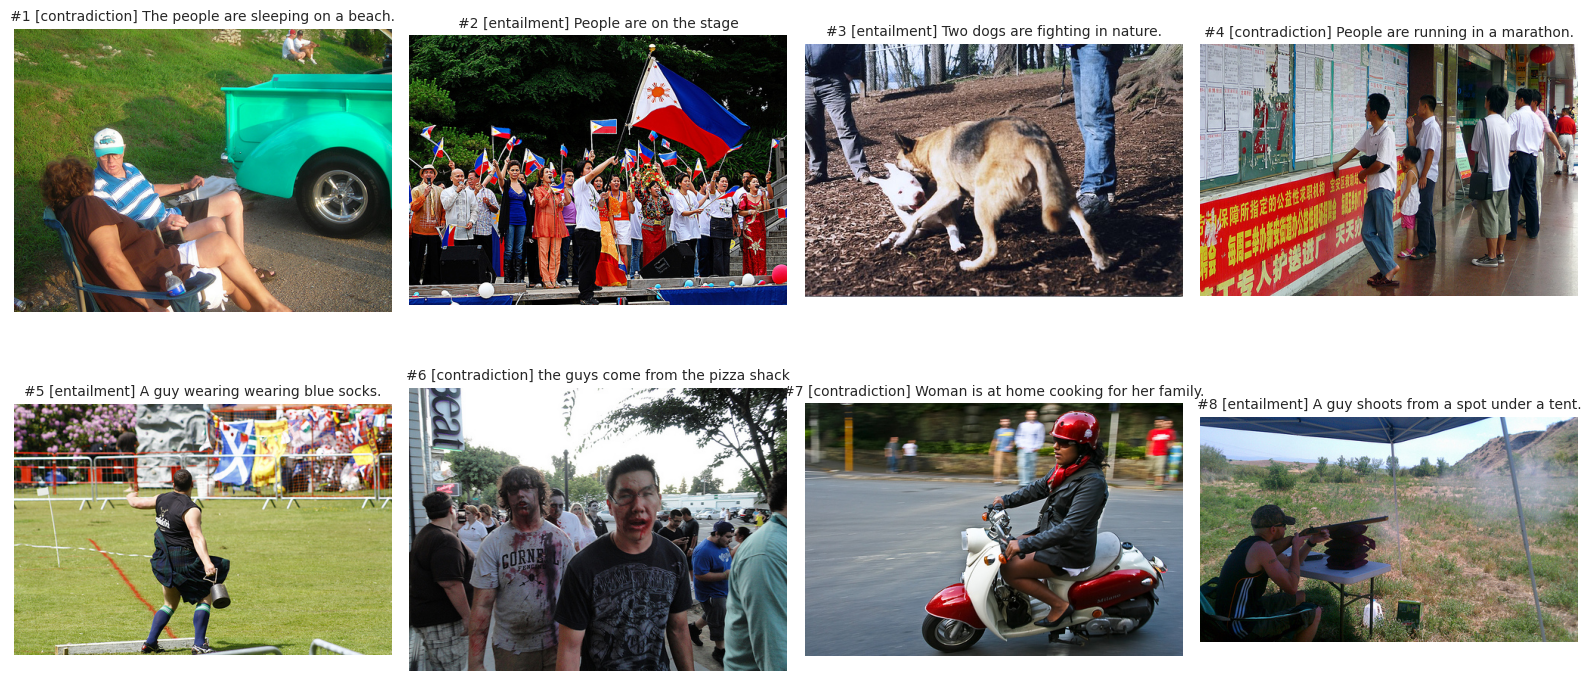

In [69]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import textwrap


# ---------- Grid view (R x C) ----------
def show_grid(df, R=2, C=3, seed=42, wrap=40):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(df), size=R*C, replace=False)
    fig, axes = plt.subplots(R, C, figsize=(4*C, 4*R))
    axes = axes.ravel()

    for num, (ax, i) in enumerate(zip(axes, idxs), start=1):
        row = df.iloc[i]
        try:
            img = Image.open(row["path"]).convert("RGB")
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error:\n{e}", ha="center", va="center")
        ax.axis("off")

        label = "entailment" if row["y"] == 1 else "contradiction"
        hypo_wrapped = "\n".join(textwrap.wrap(row["hypo"], width=wrap))
        ax.set_title(f"#{num} [{label}] {hypo_wrapped}", fontsize=10)
    plt.tight_layout()
    plt.show()
    
show_grid(df, R=2, C=4, seed=42)  


### Observation
- The dataset appears to be well aligned
- however some images might create a confusion to the model such as Image #4 is labeled contradiction for the hypothesis “People are running in a marathon.” which is correct. However, in a single 2D frame the linear alignment of people, forward-facing orientation, and street context can mimic “running posture” cues, even though everyone is actually standing and reading. A vision model that leans on global layout heuristics (row of people + sidewalk + banners) may overgeneralize and predict entailment on similar scenes, especially when verbs imply motion but no motion cues exist in still images. In normal CLS-level fusion this might get confused, as it will treat the overall sentence and image as single global summaries, whereas token level cross attention might be better. 
- In image number 4 same confusion might arise with nomal fusion of the model, though the image and label are algned correctly however if there is a image in the distribution that the people are sitting in the beach chair, then the model might get confused with picture like this as the sitting posture matches with how people sit in the beach.
- One interesting observation from Image number 5 is that it depicts a man participating in a Scottish Highland game. The caption states that the man is wearing blue socks, which is factually true. However, the model might get confused about which region of the image to focus on in order to verify that statement. This highlights a limitation of black-box visual reasoning models — they may reach the correct answer for the wrong reason. Explainability methods, such as attention visualization or saliency maps, could help reveal whether the model is indeed focusing on the relevant image region (the socks) when making the entailment decision.

### Understanding Label distribution, text length

We tried to understand both the label distribution and the hypothesis length in the dataset. The label distribution plot shows how many samples belong to each class: 0 for contradiction and 1 for entailment. This gives an early indication of whether the dataset is balanced or skewed, which is important for training a fair model. Next, we examined the length of hypotheses by counting the number of tokens in each sentence and plotting a histogram. This analysis helps decide the appropriate maximum sequence length for BERT so that most sentences are captured without unnecessary padding. Finally, we sampled a few random examples to manually check the alignment between image paths, hypotheses, and labels, ensuring that the data is correctly structured for downstream modeling.

Class counts:
 y
1    19619
0    19510
Name: count, dtype: int64


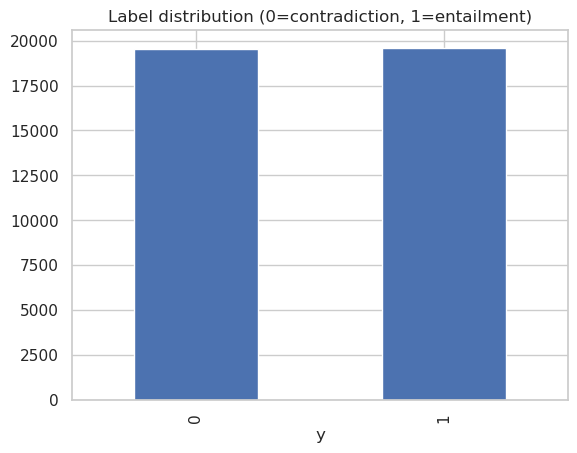

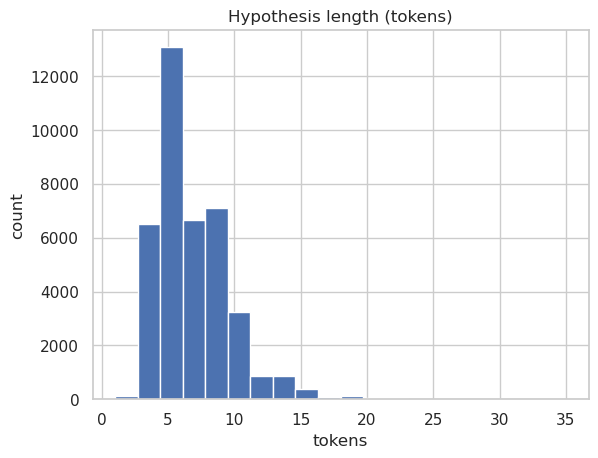

path                                      hypo  y
38567   A2_Images/448590900.jpg            the dog is playing in the snow  0
6231    A2_Images/195962790.jpg                A lady is sitting outside.  1
34954  A2_Images/3735084476.jpg  A old man is working the soil of a farm.  1

In [70]:
# === 2. EDA ===
print("Class counts:\n", df["y"].value_counts())
df["len_hypo"] = df["hypo"].str.split().apply(len)

plt.figure(); df["y"].value_counts().sort_index().plot(kind="bar")
plt.title("Label distribution (0=contradiction, 1=entailment)"); plt.show()

plt.figure(); plt.hist(df["len_hypo"], bins=20)
plt.title("Hypothesis length (tokens)"); plt.xlabel("tokens"); plt.ylabel("count"); plt.show()

# Show a few samples
df.sample(3, random_state=SEED)[["path","hypo","y"]]


### Observation
- The dataset contains 39,129 usable samples with no missing images, which confirms a clean alignment between hypotheses and visual data.
- The label distribution is almost perfectly balanced: entailment (y=1) and contradiction (y=0) are present in nearly equal proportions. This balance reduces the risk of bias toward one class during training.
- Hypothesis lengths are generally short, with most sentences between 4–12 tokens, and very few exceeding 20 tokens. This validates that a maximum sequence length of 32–35 tokens for BERT is more than sufficient, minimizing unnecessary padding.

### Checking if the image count match the hypothesis

In [71]:
# Count how many hypotheses per image_id
counts = df["image_id"].value_counts()

# Show a few images with multiple hypotheses
multi = df[df["image_id"].isin(counts[counts > 1].index)]

# Look at first few
multi.head(10)[["image_id","hypo","y"]]

image_id                                               hypo  y
0   4564320256                The old woman and a girl are bored.  1
1   4564320256           Two old men robbing a convenience store.  0
2   4564320256              A man implies that he is very strong.  0
4    369186134                           Dogs are out in the snow  1
5    369186134                               There are some dogs.  1
6   3691642887                      A kid helps a man fix a door.  1
7   3691642887  The man and boy are at the game waiting for a ...  0
8   3861381128    People are celebrating with music and costumes.  1
9   3861381128      A village celebrates a holiday in the street.  1
10  3504275465  The dog jumped over the small river and landed...  0

### Observation 
- There are multiple hypothesis for a single image
- This is normal, as for a single image there will be hypothesis that is entailment or some will be contradiction
- Since this is the case, we should to stratification while splitting the data based on the image_id as if we are doing random spliting, it might happen that same image is on the training and test set which will introduce data leakage. Stratifying by image_id ensures that all hypotheses associated with a particular image stay within the same split while still preserving the overall class distribution.

### Text length distribution
In this block we are zooming in the text to see how it is distributed

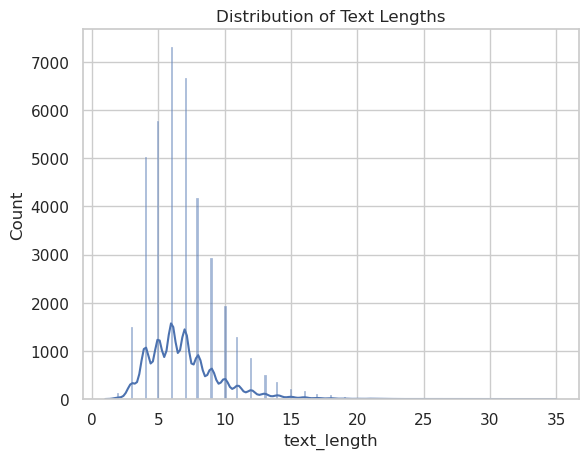

count    39129.000000
mean         6.935291
std          2.732952
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         35.000000
Name: text_length, dtype: float64


In [72]:
temp_df = pd.DataFrame()

# Calculate the length of text for each sample in words
temp_df['text_length'] = df['hypo'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths with a kernel density estimate
sns.histplot(temp_df['text_length'], kde=True)
plt.title("Distribution of Text Lengths")
plt.show()

# Display descriptive statistics for text lengths to check for outliers
print(temp_df['text_length'].describe())

## Observations
- The dataset has 39,129 hypotheses in total.
- The average length of hypotheses is about 6.9 words, with a standard deviation of 2.7, meaning most sentences are short and don’t vary too much in length.
- The minimum length is 1 word and the maximum is 35 words.
- 50% of the hypotheses are 6 words or fewer, and 75% are 8 words or fewer.
- The KDE plot shows a strong peak between 5–8 words, confirming that the majority of hypotheses are concise.
- Only a very small number of samples approach the upper bound of 30–35 words, which means setting a BERT max sequence length of 32–35 tokens is safe and will capture all hypotheses without much truncation.

### Sanity Check of the text
We want to catch textual artefacts (hyperlinks, emojis, email/user handles, weird punctuation, shouting/all-caps, non-ASCII symbols) which can distract the model or break tokenization. So we scan each hypothesis, sets per-row flags, summarizes prevalence, and print the outliers.

In [73]:
import re
import pandas as pd

# --- regex helpers ---
url_re     = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
email_re   = re.compile(r'\b[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}\b', re.IGNORECASE)
user_re    = re.compile(r'(^|[\s:])[@#][A-Za-z0-9_]+')   # @handle or #hashtag
emoji_re   = re.compile(
    r'['
    r'\U0001F300-\U0001F6FF'  # symbols & pictographs
    r'\U0001F700-\U0001F77F'
    r'\U0001F780-\U0001F7FF'
    r'\U0001F800-\U0001F9FF'
    r'\U0001FA00-\U0001FAFF'
    r'\U00002600-\U000026FF'  # misc symbols
    r'\U00002700-\U000027BF'
    r']'
)
nonascii_re = re.compile(r'[^\x00-\x7F]')               # any non-ASCII char
multi_punct = re.compile(r'[!?]{2,}|(\.\s*){3,}')       # !!, ???, ... (3+ dots)
repeat_char = re.compile(r'(.)\1{3,}', re.IGNORECASE)   # aaaa, !!!!, etc.

def has_url(s):     return bool(url_re.search(s))
def has_email(s):   return bool(email_re.search(s))
def has_user(s):    return bool(user_re.search(s))
def has_emoji(s):   return bool(emoji_re.search(s))
def has_nonascii(s):return bool(nonascii_re.search(s))
def has_multi_punct(s): return bool(multi_punct.search(s))
def has_repeat_char(s): return bool(repeat_char.search(s))
def has_allcaps_token(s):
    toks = re.findall(r"\b[A-Za-z]{2,}\b", s)
    return any(t.isupper() for t in toks)

# --- add flags to df ---
col = "hypo"
df["has_url"]        = df[col].str.contains(url_re)
df["has_email"]      = df[col].str.contains(email_re)
df["has_user"]       = df[col].str.contains(user_re)
df["has_emoji"]      = df[col].str.contains(emoji_re)
df["has_nonascii"]   = df[col].str.contains(nonascii_re)
df["has_multi_punct"]= df[col].str.contains(multi_punct)
df["has_repeat_char"]= df[col].str.contains(repeat_char)
df["has_allcaps"]    = df[col].apply(has_allcaps_token)

# --- prevalence summary ---
flags = ["has_url","has_email","has_user","has_emoji","has_nonascii",
         "has_multi_punct","has_repeat_char","has_allcaps"]

summary = (df[flags].mean().sort_values(ascending=False) * 100).round(2)
print("Noise feature prevalence (% of rows):\n", summary.to_string())

# --- peek at a few examples per issue ---
def show_examples(flag, k=5):
    ex = df.loc[df[flag], [col]].head(k)
    print(f"\nExamples for {flag} ({len(ex)} shown):")
    for i, t in enumerate(ex[col].tolist(), 1):
        print(f"{i:>2}. {t}")

for f in flags:
    if df[f].any():
        show_examples(f, k=3)


/tmp/ipykernel_7508/3125258016.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_user"]       = df[col].str.contains(user_re)
/tmp/ipykernel_7508/3125258016.py:41: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_multi_punct"]= df[col].str.contains(multi_punct)
/tmp/ipykernel_7508/3125258016.py:42: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_repeat_char"]= df[col].str.contains(repeat_char)


Noise feature prevalence (% of rows):
 has_allcaps        0.44
has_url            0.00
has_multi_punct    0.00
has_email          0.00
has_emoji          0.00
has_user           0.00
has_nonascii       0.00
has_repeat_char    0.00

Examples for has_url (1 shown):
 1. http://fresnosmilemakeovers.com/

Examples for has_multi_punct (1 shown):
 1. And slar and slue...

Examples for has_allcaps (3 shown):
 1. A lifeguard is giving CPR to a man he just dragged out of the ocean.
 2. THERE ARE TOYS BEING PLAYED WITH BY A CHILD IN PAJAMAS
 3. A man and a child watched TV.


### Observation
- URLs, emails, emojis, and user handles were found in 0% of rows, confirming there are no hyperlinks or social media artifacts.
- Only 0.44% of samples contain ALL-CAPS words, such as “CPR” or entire sentences in uppercase. These are rare and not harmful, as they often represent acronyms or emphasis rather than noise.
- Minor punctuation anomalies (like ellipses “…”) appeared in isolated cases.

### Remedy
- Though the dataset appears overall very clean, we can normalize ALL-CAPS words to lowercase (except known acronyms like “CPR”,"TV") and trim extra punctuation.

### Checking for negation

This block extends the EDA by looking at linguistic features of the hypotheses, especially focusing on negations. The motivation here is that negation words (“not”, “never”, “no”, etc.) often flip the meaning of a sentence and are highly relevant in entailment/contradiction tasks. By explicitly checking their prevalence, we get an idea of how much the dataset challenges the model to reason about negation.

          len_words     len_chars
count  39129.000000  39129.000000
mean       6.935291     34.865522
std        2.732952     14.044893
min        1.000000      1.000000
25%        5.000000     25.000000
50%        6.000000     32.000000
75%        8.000000     41.000000
max       35.000000    204.000000


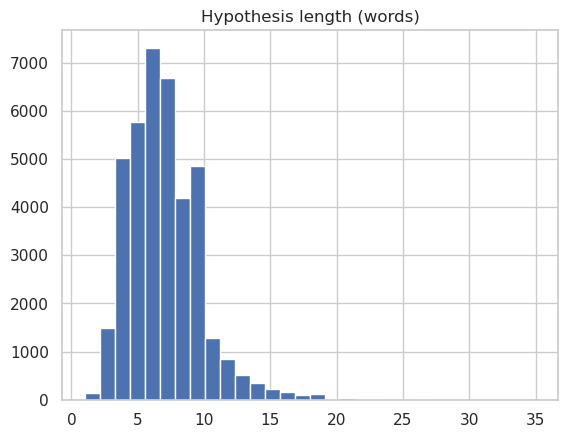

Negation prevalence: 0.02680876076567252


In [74]:
neg_words = {"no","not","none","never","without","nothing","nobody","isn't","aren't","wasn't","weren't","don't","doesn't","didn't","can't","cannot","won't","wouldn't","shouldn't"}

df["len_words"] = df["hypo"].str.split().str.len()
df["len_chars"] = df["hypo"].str.len()
df["has_neg"]   = df["hypo"].str.lower().apply(lambda s: any(w in s.split() for w in neg_words))

print(df[["len_words","len_chars","has_neg"]].describe())
plt.figure(); plt.hist(df["len_words"], bins=30); plt.title("Hypothesis length (words)"); plt.show()
print("Negation prevalence:", df["has_neg"].mean())


## Observation 
- In terms of characters, the average length is ~35 characters, with some longer outliers up to 204 characters.
- The histogram confirms a strong concentration of hypotheses around short lengths, with very few extending beyond 15 words.
- Negation prevalence is about 2.7% of all hypotheses. This indicates that explicit negation words are relatively rare in the dataset, but they are crucial cases since they often drive contradiction labels.

### Checking duplicate data to prevent leak

In [75]:
dup_exact = df.duplicated(subset=["image_id","hypo","y"])
print("Exact duplicates:", dup_exact.sum())
df[dup_exact].head()


Exact duplicates: 7


image_id                      path  \
1399   3389458786  A2_Images/3389458786.jpg   
3485   4970780316  A2_Images/4970780316.jpg   
8851   3128965175  A2_Images/3128965175.jpg   
10931  4171253174  A2_Images/4171253174.jpg   
11446  2813005964  A2_Images/2813005964.jpg   

                                           hypo  y  len_hypo  has_url  \
1399   The boy and girl are wearing sweatpants.  0         7    False   
3485                        A woman by a fence.  1         5    False   
8851                     A girl plays checkers.  1         4    False   
10931             The woman is wearing clothes.  1         5    False   
11446                         A girl is eating.  1         4    False   

       has_email  has_user  has_emoji  has_nonascii  has_multi_punct  \
1399       False     False      False         False            False   
3485       False     False      False         False            False   
8851       False     False      False         False            False   
10931      False     False      False         False            False   
11446      False     False      False         False            False   

       has_repeat_char  has_allcaps  len_words  len_chars  has_neg  
1399             False        False          7         40    False  
3485             False        False          5         19    False  
8851             False        False          4         22    False  
10931            False        False          5         29    False  
11446            False        False          4         17    False

## Observation
- In the dataset there are total 7 duplicate value
- However this duplicate data may induce data leakage which should be taken care of

## Remedy
- We should remove exact duplicates using drop_duplicates on (image_id, hypo, y).
- We should also check for label conflicts (same (image_id, hypothesis) with different labels) and resolve them by majority vote, while dropping ties to avoid ambiguity.

## Data Cleaning

### Cleaning duplicate data and noise
This cell audits and cleans duplicates specific to visual–textual entailment. Because each image can legitimately appear with many hypotheses, we first quantify harmless image reuse, then isolate true issues: (a) exact duplicate rows where the same (image_id, hypothesis, label) is repeated, and (b) label conflicts where the same (image_id, hypothesis) has both labels (0 and 1). Exact duplicates inflate sample weight and risk leakage across splits; conflicts indicate annotation inconsistency. The cleaning policy removes exact duplicates, then resolves conflicts by majority vote per (image_id, hypothesis) and drops ties to stay conservative. Finally, assertions verify paths exist, labels are valid, and hypotheses are non-empty (while allowing multiple hypotheses per image, which is normal in VE). The result is a deduplicated, self-consistent dataset that reduces leakage risk and training bias. Afterwards we applied a light text cleaner that strips rare URLs/emails, collapses excessive punctuation, and normalizes non-acronym ALL-CAPS tokens (keeping acronyms like CPR/TV/USA). The function returns a cleaned DataFrame (df_clean) plus a small report summarizing rows before/after, duplicates removed, conflicts handled, and final class distribution—making the preprocessing transparent, leakage-resistant, and ready for group-stratified splitting and training.

In [76]:
import re
import pandas as pd
import os

# ---------- light text cleaner ----------
def clean_hypothesis(text):
    if not isinstance(text, str):
        return text
    # remove URLs & emails
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\b[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}\b', '', text)
    # collapse excessive punctuation
    text = re.sub(r'([!?]){2,}', r'\1', text)
    text = re.sub(r'\.{3,}', '.', text)
    # normalize ALL-CAPS except known acronyms
    acronyms = {"CPR","USA","TV","NASA"}
    toks = []
    for tok in text.split():
        toks.append(tok if not (tok.isupper() and tok not in acronyms) else tok.lower())
    text = " ".join(toks)
    # normalize spaces
    return re.sub(r'\s+', ' ', text).strip()

# ---------- full dataset cleaner (your dedup + conflicts + text) ----------
def clean_dataset(df):
    df = df.copy()
    report = {}

    # A) measure before
    report["rows_before"] = len(df)

    # B) harmless reuse count (FYI)
    report["image_reuse_rows"] = int(df["image_id"].duplicated().sum())

    # C) exact duplicates
    dup_exact_mask = df.duplicated(subset=["image_id","hypo","y"])
    report["dup_exact_found"] = int(dup_exact_mask.sum())
    if report["dup_exact_found"] > 0:
        df = df.drop_duplicates(subset=["image_id","hypo","y"]).copy()

    # D) label conflicts (same image_id + hypo, different y)
    conflicts = (
        df.groupby(["image_id","hypo"])["y"]
          .nunique()
          .reset_index(name="n_labels")
          .query("n_labels > 1")
    )
    report["label_conflicts_found"] = int(len(conflicts))

    if len(conflicts):
        counts = (
            df.groupby(["image_id","hypo","y"]).size()
              .reset_index(name="cnt")
        )
        winners = counts.loc[counts.groupby(["image_id","hypo"])["cnt"].idxmax()]
        # detect ties
        tie_mask = (
            counts.merge(
                winners[["image_id","hypo","cnt"]],
                on=["image_id","hypo","cnt"],
                how="right"
            ).groupby(["image_id","hypo"]).size().gt(1)
        )
        ties = tie_mask[tie_mask].index if hasattr(tie_mask, "index") else []
        report["label_ties_dropped_pairs"] = int(len(ties)) if len(conflicts) else 0

        keep_pairs = set(zip(winners["image_id"], winners["hypo"], winners["y"]))
        df = df[[ (iid, h, y) in keep_pairs for iid, h, y in zip(df.image_id, df.hypo, df.y) ]].copy()

    # E) assertions after structure clean
    assert (df["path"].apply(os.path.exists)).all(), "Some image paths are missing."
    assert df["y"].isin([0,1]).all(), "Found invalid labels."
    assert df["hypo"].astype(str).str.strip().ne("").all(), "Found empty hypotheses."

    # F) text cleaning (light)
    df["hypo"] = df["hypo"].apply(clean_hypothesis)

    # G) measure after
    report["rows_after"] = len(df)
    report["class_dist_after"] = df["y"].value_counts(normalize=True).round(3).to_dict()

    print(
        "Clean OK:",
        f"rows {report['rows_before']} -> {report['rows_after']};",
        f"exact dups removed={report['dup_exact_found']};",
        f"conflicts={report['label_conflicts_found']};",
        f"ties_dropped={report.get('label_ties_dropped_pairs', 0)};",
        f"class_dist={report['class_dist_after']}"
    )
    return df, report

# ---------- usage ----------
df_clean, clean_report = clean_dataset(df)


Clean OK: rows 39129 -> 39122; exact dups removed=7; conflicts=0; ties_dropped=0; class_dist={1: 0.501, 0: 0.499}


### Image quality check

This block performs an image-level EDA to check the quality and distribution of the visual data. Instead of just relying on filenames, it opens each image from a random sample of 3000, extracts key metadata, and computes simple statistics related to brightness, contrast, and sharpness. The aim is to catch problems such as corrupt images, extreme aspect ratios, or very dark/blurry samples that could affect model training.

Corrupt images in sample: 0


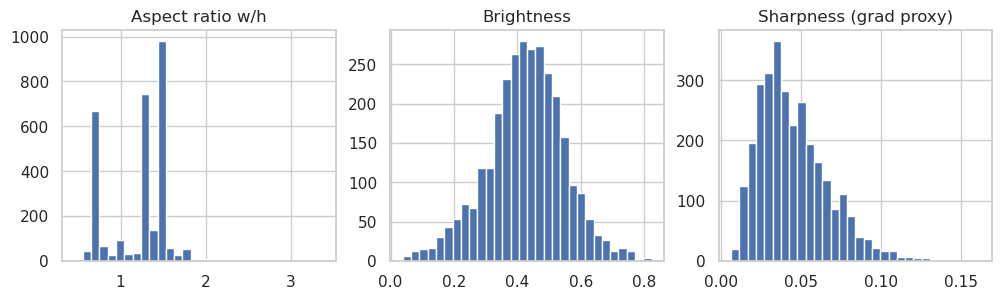

In [77]:
from PIL import Image
import numpy as np, os, pandas as pd, matplotlib.pyplot as plt

def image_meta(path):
    try:
        with Image.open(path) as im:
            w, h = im.size
            gray = im.convert("L")
            arr  = np.asarray(gray, dtype=np.float32) / 255.0
            bright   = float(arr.mean())             # 0..1
            contrast = float(arr.std())              # 0..~0.3
            # simple sharpness proxy: mean gradient magnitude (no OpenCV needed)
            gx = np.abs(np.diff(arr, axis=1)).mean()
            gy = np.abs(np.diff(arr, axis=0)).mean()
            sharp = float((gx + gy) / 2)
            size_bytes = os.path.getsize(path)
            ext = os.path.splitext(path)[1].lower()
            return w, h, (w/h), bright, contrast, sharp, size_bytes, ext, 1
    except Exception:
        return None, None, None, None, None, None, None, None, 0  # corrupt

# sample or full set
sample_paths = df["path"].sample(min(3000, len(df_clean)), random_state=42).tolist()
meta = [image_meta(p) for p in sample_paths]
meta_df = pd.DataFrame(meta, columns=["w","h","aspect","brightness","contrast","sharp","bytes","ext","ok"])

print("Corrupt images in sample:", (meta_df["ok"]==0).sum())
fig, axes = plt.subplots(1,3, figsize=(12,3))
axes[0].hist(meta_df["aspect"].dropna(), bins=30); axes[0].set_title("Aspect ratio w/h")
axes[1].hist(meta_df["brightness"].dropna(), bins=30); axes[1].set_title("Brightness")
axes[2].hist(meta_df["sharp"].dropna(), bins=30); axes[2].set_title("Sharpness (grad proxy)")
plt.show()

## Observations 
- Corrupt images: None were detected in the 3,000-image sample, confirming the dataset is intact.
- Aspect ratio: The distribution shows a few dominant peaks, mostly around 1.0–1.7. This suggests that the images are not all uniform in shape, but most fall into standard photographic proportions (close to square or landscape). Extreme aspect ratios (>2.5) are rare, so resizing to a fixed input size (e.g., 224×224 for EfficientNet) is safe.
- Brightness: The histogram is approximately bell-shaped and centered around 0.4–0.5, meaning most images have mid-level brightness. Very dark (<0.2) or very bright (>0.7) samples are uncommon, so overall exposure quality looks good.
- Sharpness: The majority of images cluster around 0.02–0.06 (gradient proxy), showing they contain enough edges and detail. A small tail toward lower sharpness values indicates a few blurry images, but not in significant numbers.

## Data Splitting
We are doing stratified data splitting to make sure the dataset is divided fairly and without any data leakage. Since multiple samples can come from the same image (identified by "image_id"), a normal random split could accidentally place parts of the same image into both training and testing sets, which would make the model’s performance look unrealistically good. To avoid this, we group the data by "image_id" so that all samples from the same image stay together in a single split. At the same time, we use stratification based on the label "y" to maintain a similar class balance across train, validation, and test sets. We perform the splitting in two stages, first to separate out the test set (15%) and then to divide the remaining data into training and validation sets so that the test data remains completely unseen until final evaluation. Finally, we run summary checks to confirm that the splits are balanced and that no image appears in more than one split.


In [78]:
# ============================================
# Group-stratified Split by image_id + post-split check
# ============================================
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

# prepare arrays
X = df_clean.index
y = df_clean["y"]
groups = df_clean["image_id"]

# First split: train+val vs test (15% test)
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=SEED)
trainval_idx, test_idx = next(sgkf.split(X, y, groups))

trainval_df = df.iloc[trainval_idx].copy()
test_df     = df.iloc[test_idx].copy()

# Second split: train vs val (15% of trainval for validation)
y_tv = trainval_df["y"]
g_tv = trainval_df["image_id"]
sgkf2 = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=SEED)
train_idx, val_idx = next(sgkf2.split(trainval_df.index, y_tv, g_tv))

train_df = trainval_df.iloc[train_idx].copy()
val_df   = trainval_df.iloc[val_idx].copy()

# ensure len_words exists
for frame in (train_df, val_df, test_df):
    if "len_words" not in frame.columns:
        frame["len_words"] = frame["hypo"].str.split().str.len()

# summary check
for name, d in [("train", train_df), ("val", val_df), ("test", test_df)]:
    mu = float(d["len_words"].mean())
    sigma = float(d["len_words"].std())
    print(
        name,
        "size=", len(d),
        "label dist=", d["y"].value_counts(normalize=True).round(3).to_dict(),
        "len_words μ±σ=", (round(mu, 2), round(sigma, 2)),
        "unique images=", d["image_id"].nunique()
    )



train size= 31674 label dist= {1: 0.501, 0: 0.499} len_words μ±σ= (6.93, 2.73) unique images= 16478
val size= 3482 label dist= {1: 0.503, 0: 0.497} len_words μ±σ= (6.95, 2.75) unique images= 1846
test size= 3966 label dist= {1: 0.505, 0: 0.495} len_words μ±σ= (6.95, 2.75) unique images= 2889


In [79]:
import tensorflow as tf
import keras, keras_hub
from keras import layers

IMG_SIZE = (224, 224)
SEQ_LEN  = 32
PRESET   = "bert_small_en_uncased"  # pick a preset you have

# image loader / augment (pure keras layers)
def decode_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape((*IMG_SIZE, 3))
    return img

augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomContrast(0.1),
], name="img_aug")

# --- Instantiate the KerasHub preprocessor ONCE (outside the model) ---
try:
    preproc = keras_hub.models.BertPreprocessor.from_preset(PRESET, sequence_length=SEQ_LEN)
except AttributeError:
    # fallback for versions exposing a generic classifier preprocessor
    preproc = keras_hub.models.TextClassifierPreprocessor.from_preset(PRESET, sequence_length=SEQ_LEN)

# Make sure you have these in scope:
# preproc = keras_hub.models.BertPreprocessor.from_preset(PRESET, sequence_length=SEQ_LEN)
# or the TextClassifierPreprocessor fallback, as you used before.

def _bert_pack(hypo_str):
    """
    Robustly run KerasHub BERT preprocessor in tf.data:
    - Expand dims to [1] so outputs are [1, SEQ_LEN]
    - Then squeeze back to [SEQ_LEN]
    - Normalize key names across versions
    """
    h = tf.expand_dims(hypo_str, 0)         # [1]
    out = preproc(h)                         # dict with [1, SEQ_LEN] tensors

    # key normalization (some versions use 'segment_ids', others 'token_type_ids')
    seg_key = "segment_ids"
    if seg_key not in out:
        seg_key = "token_type_ids" if "token_type_ids" in out else None

    token_ids    = tf.squeeze(out["token_ids"],    axis=0)   # (SEQ_LEN,)
    padding_mask = tf.squeeze(out["padding_mask"], axis=0)   # (SEQ_LEN,)
    if seg_key is not None:
        segment_ids = tf.squeeze(out[seg_key], axis=0)       # (SEQ_LEN,)
    else:
        segment_ids = tf.zeros_like(token_ids)               # (SEQ_LEN,)

    # set static shapes for tf.function tracing
    token_ids.set_shape((SEQ_LEN,))
    segment_ids.set_shape((SEQ_LEN,))
    padding_mask.set_shape((SEQ_LEN,))

    # (types are usually int32/int32/bool already; enforce if needed)
    token_ids    = tf.cast(token_ids, tf.int32)
    segment_ids  = tf.cast(segment_ids, tf.int32)
    padding_mask = tf.cast(padding_mask, tf.bool)

    return token_ids, segment_ids, padding_mask


def make_ds_bert(frame, training: bool, batch=32):
    ds = tf.data.Dataset.from_tensor_slices(
        (frame["path"].values, frame["hypo"].values, frame["y"].values)
    )
    if training:
        ds = ds.shuffle(len(frame), seed=42)

    def _map(p, h, y):
        img = decode_image(p)
        if training:
            img = augment(img)
        tok, seg, mask = _bert_pack(h)
        features = {
            "image": img,
            "token_ids": tok,
            "segment_ids": seg,
            "padding_mask": mask,
        }
        return features, tf.cast(y, tf.float32)

    return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)\
             .batch(batch)\
             .prefetch(tf.data.AUTOTUNE)


## Evaluation Metric and Model Development Strategy



The data used in this project is derived from the SNLI-VE dataset, introduced in the paper *“Visual Entailment: A Novel Task for Fine-Grained Image Understanding”* by **Xie et al. (2019)**. This dataset extends the textual **SNLI** corpus into a visual-language task, pairing each textual hypothesis with an image premise. In their work, the authors’ proposed **EVE (Explainable Visual Entailment)** model achieved an **accuracy of approximately 71%** on the SNLI-VE test set, this result serves a strong reference point.

### Model Development

We have addopted iterative approach in the project:

1. **Baseline model:**  
   - Both BERT(text) and EfficientNet-B0(image) backbones are frozen.  
   - A Cross-Attention Block is trained on top to allow the `[CLS]` token from BERT to directly attend to image region embeddings.  
   - This stage focuses on learning cross-modal alignment and preserving the pretrained feature extractors.  

2. **Main model:**  
   - Both BERT and EfficientNet-B0 are unfrozen and fine-tuned jointly, started from the weights obtained in the baseline.  
   - This progressive fine-tuning enables joint optimization of both modalities, which leads to stronger multimodal representations and more stable convergence.

### Evaluation Rationale

Since the dataset is balanced across classes and it is a binary task, accuracy is chosen as the primary evaluation metric. It provides an interpretable and direct measure of overall correctness and aligns with the evaluation standard used in the SNLI-VE paper, this ensures the results aare comparable to the reported 71% baseline.

In addition, AUC (Area Under the ROC Curve) is monitored as a secondary metric to assess the model’s threshold-independent discriminative ability.

Other metrics such as precision, recall, and F1-score are not emphasized here, as they are primarily beneficial for imbalanced datasets or cases where one class is of particular interest. In this balanced entailment setting, they typically mirror the accuracy trend without offering significant additional insight.

### Target Performance

The goal is to achieve an accuracy of around 80%, surpassing the 71% baseline reported by *Xie et al. (2019)*. This would demonstrate that the integration of a cross-attention mechanism and iterative fine-tuning contributes to a measurable improvement in visual-textual reasoning performance.

---

**Reference:**  
Xie, N., Lai, F., Doran, D., & Kadav, A. (2019). *Visual Entailment: A Novel Task for Fine-Grained Image Understanding.* arXiv preprint [arXiv:1901.06706](https://arxiv.org/abs/1901.06706).


In [80]:
# metrics
common_metrics = [
    keras.metrics.BinaryAccuracy(name="acc"),
    keras.metrics.AUC(name="auc", curve="ROC")
]

### Creating Dataset 

In [81]:
train_ds = make_ds_bert(train_df, training=True,  batch=32)
val_ds   = make_ds_bert(val_df,   training=False, batch=32)


<h2 style="text-align: center;">Building Baseline Model</h1>

### Designing Cross-Attention Block (CLS -> Image tokens)
We designed the Cross-Attention Block to allow effective interaction between the textual and visual features. The goal is for the [CLS] token from BERT to selectively attend to relevant image regions extracted by EfficientNet-B0. The block follows a transformer-style structure with query, key, and value projections feeding into a multi-head attention layer. We included layer normalization and residual connections to ensure stable training and smooth gradient flow. To reduce overfitting, we applied L2 regularization to the projection and feed-forward layers, encouraging the model to learn smoother and more generalizable weights. Dropout was also added after the attention and feed-forward layers to improve robustness. This design enables the model to capture meaningful cross-modal relationships while maintaining good generalization performance.


In [82]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers


class CrossAttentionBlock(keras.layers.Layer):
    """CLS (text) attends over image tokens; caches attention scores for XAI."""
    def __init__(self, d_model=256, num_heads=4, ffn_mult=4,
                 dropout=0.1, l2=1e-4, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        reg = regularizers.l2(l2) if l2 else None

        self.q_proj = layers.Dense(d_model, use_bias=False, kernel_regularizer=reg, name="q_proj")
        self.k_proj = layers.Dense(d_model, use_bias=False, kernel_regularizer=reg, name="k_proj")
        self.v_proj = layers.Dense(d_model, use_bias=False, kernel_regularizer=reg, name="v_proj")

        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model // num_heads,
            dropout=dropout, kernel_regularizer=reg, name="xattn"
        )

        self.dropout = layers.Dropout(dropout)
        self.ln1 = layers.LayerNormalization(epsilon=1e-6, name="ln1")
        self.cls_proj = layers.Dense(d_model, use_bias=False, kernel_regularizer=reg, name="cls_proj")

        self.ffn = keras.Sequential([
            layers.Dense(ffn_mult * d_model, activation="relu", use_bias=True, kernel_regularizer=reg),
            layers.Dropout(dropout),
            layers.Dense(d_model, use_bias=True, kernel_regularizer=reg),
        ], name="ffn")
        self.ln2 = layers.LayerNormalization(epsilon=1e-6, name="ln2")

        # NEW: cache attention scores for visualization
        self.last_attn = None  # (B, heads, T_q, T_k)

    def call(self, cls_vec, img_tokens, training=False):
        # cls_vec: (B,1,d_t), img_tokens: (B,P,d_i)
        Q = self.q_proj(cls_vec)
        K = self.k_proj(img_tokens)
        V = self.v_proj(img_tokens)

        # NEW: ask MHA to return attention scores and cache them
        attn_out, attn_scores = self.mha(
            query=Q, key=K, value=V, return_attention_scores=True, training=training
        )
        self.last_attn = attn_scores  # (B, heads, T_q=1, T_k=P)

        x = self.dropout(attn_out, training=training)

        # Residual 1
        cls_res = self.cls_proj(cls_vec) if cls_vec.shape[-1] != x.shape[-1] else cls_vec
        x = self.ln1(x + cls_res)

        # FFN + Residual 2
        y = self.ffn(x, training=training)
        y = self.dropout(y, training=training)
        y = self.ln2(x + y)
        return y  # (B,1,d_model)






### Cross-Attention Model Builder



In [83]:
def build_crossatt_bert_effnet(
    img_shape=(224,224,3),
    preset="bert_base_en_uncased",
    seq_len=128,
    d_model=256,
    num_heads=4,
    ffn_mult=4,
    num_xatt_blocks=1,
    dropout=0.1
):
    # ----- Image branch -----
    img_in   = layers.Input(shape=img_shape, name="image")
    img_base = keras.applications.EfficientNetB0(include_top=False, input_shape=img_shape, weights="imagenet")
    img_base.trainable = False  # start frozen
    fmap = img_base(img_in, training=False)            # (B, H, W, C)
    tokens = layers.Reshape((-1, fmap.shape[-1]))(fmap)  # (B, P, C)
    img_proj = layers.Dense(d_model, name="img_proj")(tokens)  # (B, P, d_model)

    # ----- Text branch (KerasHub BERT) -----
    token_ids_in    = layers.Input(shape=(seq_len,), dtype="int32", name="token_ids")
    segment_ids_in  = layers.Input(shape=(seq_len,), dtype="int32", name="segment_ids")
    padding_mask_in = layers.Input(shape=(seq_len,), dtype="bool",  name="padding_mask")

    bert_in = {"token_ids": token_ids_in, "segment_ids": segment_ids_in, "padding_mask": padding_mask_in}
    bert = keras_hub.models.BertBackbone.from_preset(preset)
    bert.trainable = False
    bert_out = bert(bert_in)                                # dict
    cls = bert_out["pooled_output"]                         # (B, d_text) == CLS
    cls = layers.Dense(d_model, name="cls_proj")(cls)       # (B, d_model)
    cls = layers.Reshape((1, d_model))(cls)                 # (B, 1, d_model)

    # ----- Cross-Attention (CLS -> image tokens) -----
    x = cls
    for i in range(num_xatt_blocks):
        x = CrossAttentionBlock(d_model=d_model, num_heads=num_heads, ffn_mult=ffn_mult,
                                dropout=dropout, name=f"xatt_{i+1}")(x, img_proj)

    # ----- Head -----
    h = layers.Flatten()(x)                        # (B, d_model)
    h = layers.Dropout(dropout)(h)
    h = layers.Dense(256, activation="relu")(h)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(dropout)(h)
    out = layers.Dense(1, activation="sigmoid")(h)

    model = keras.Model(
        inputs={"image": img_in, "token_ids": token_ids_in, "segment_ids": segment_ids_in, "padding_mask": padding_mask_in},
        outputs=out,
        name="crossatt_bert_effnet_cls2img"
    )
    return model


In [84]:
# Build cross-attention model (baseline+)
xatt_model = build_crossatt_bert_effnet(
    img_shape=(224,224,3),
    preset=PRESET,
    seq_len=SEQ_LEN,
    d_model=256,
    num_heads=4,
    ffn_mult=4,
    num_xatt_blocks=1,
    dropout=0.2
)

xatt_model.summary()

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'xatt_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "crossatt_bert_effnet_cls2img"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 512),     │ 28,763,648 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, 32, 512)]  │            │ segment_ids[0][0… │
│                     │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image[0][0]       │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_proj (Dense)    │ (None, 256)       │    131,328 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 49, 1280)  │          0 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1, 256)    │          0 │ cls_proj[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_proj (Dense)    │ (None, 49, 256)   │    327,936 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xatt_1              │ (None, 1, 256)    │    986,368 │ reshape_7[0][0],  │
│ (CrossAttentionBlo… │                   │            │ img_proj[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 256)       │          0 │ xatt_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_62          │ (None, 256)       │          0 │ flatten_3[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │     65,792 │ dropout_62[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_22[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_63          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │        257 │ dropout_63[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,325,924 (130.94 MB)

 Trainable params: 1,512,193 (5.77 MB)

 Non-trainable params: 32,813,731 (125.17 MB)

## Run till here for first

In [ ]:
something wrong

### Training Baseline Model

Epoch 1/100


2025-10-10 08:26:38.912044: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1760084814.340251    1236 service.cc:152] XLA service 0x7f1ef80d9060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760084814.340281    1236 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-10-10 08:26:55.065058: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760084818.140283    1236 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/990 ━━━━━━━━━━━━━━━━━━━━ 11:00:35 40s/step - acc: 0.4688 - auc: 0.5059 - loss: 0.9824

I0000 00:00:1760084838.403095    1236 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


990/990 ━━━━━━━━━━━━━━━━━━━━ 570s 535ms/step - acc: 0.5286 - auc: 0.5406 - loss: 1.0016 - val_acc: 0.6379 - val_auc: 0.6979 - val_loss: 0.7941 - learning_rate: 2.0000e-05
Epoch 2/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 334s 337ms/step - acc: 0.5816 - auc: 0.6138 - loss: 0.8963 - val_acc: 0.6462 - val_auc: 0.7102 - val_loss: 0.7795 - learning_rate: 2.0000e-05
Epoch 3/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 333s 336ms/step - acc: 0.5923 - auc: 0.6286 - loss: 0.8677 - val_acc: 0.6513 - val_auc: 0.7203 - val_loss: 0.7691 - learning_rate: 2.0000e-05
Epoch 4/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 334s 337ms/step - acc: 0.6097 - auc: 0.6536 - loss: 0.8358 - val_acc: 0.6582 - val_auc: 0.7238 - val_loss: 0.7562 - learning_rate: 2.0000e-05
Epoch 5/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 332s 335ms/step - acc: 0.6075 - auc: 0.6529 - loss: 0.8281 - val_acc: 0.6465 - val_auc: 0.7290 - val_loss: 0.7682 - learning_rate: 2.0000e-05
Epoch 6/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 332s 335ms/step - acc: 0.6122 - auc: 0.6619 - loss: 0.81

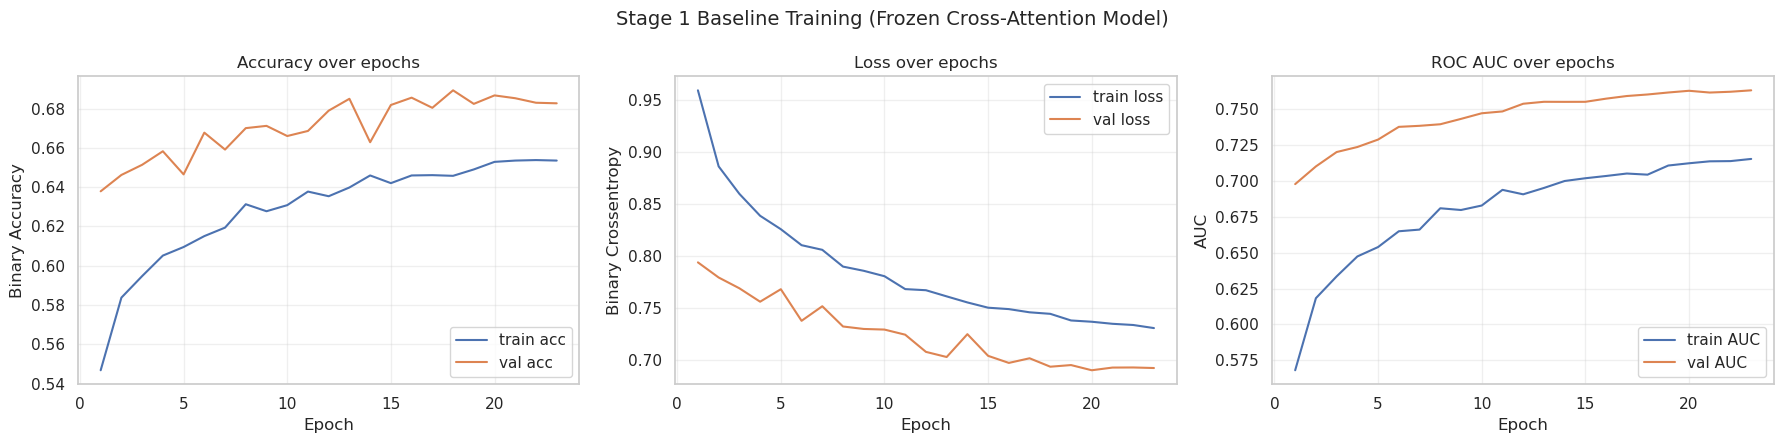

In [23]:
# top of cell
import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import AdamW
tf.keras.backend.clear_session()

# Stage 1: Compile the freezed model

opt_xatt = AdamW(learning_rate=2e-5, weight_decay=3e-5, clipnorm=1.0)
xatt_model.compile(
    optimizer=opt_xatt,
    loss="binary_crossentropy",
    metrics=common_metrics
)

cbs_s1_xatt = [
    ModelCheckpoint("artifacts/best_s1_xatt.keras", monitor="val_acc", mode="max", save_best_only=True),
    EarlyStopping(monitor="val_acc", mode="max", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.5, patience=2, min_lr=1e-6),
]

# Stage 1: train with frozen backbones
hist1 = xatt_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=cbs_s1_xatt, verbose=1)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Convert training history to DataFrame ---
hist_df = pd.DataFrame(hist1.history)
hist_df["epoch"] = np.arange(1, len(hist_df) + 1)

# --- Helper to safely fetch metrics (handles alias names) ---
def get_col(df, key):
    if key in df.columns:
        return df[key].values
    alt = {
        "acc": ["accuracy", "binary_accuracy"],
        "val_acc": ["val_accuracy", "val_binary_accuracy"],
        "auc": ["AUC", "roc_auc"],
        "val_auc": ["val_AUC", "val_roc_auc"],
    }
    if key in alt:
        for k in alt[key]:
            if k in df.columns:
                return df[k].values
    raise KeyError(f"Metric '{key}' not found in columns: {list(df.columns)}")

# --- Plot Loss, Accuracy, and AUC ---
plt.figure(figsize=(18, 4.5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(hist_df["epoch"], get_col(hist_df, "acc"), label="train acc")
plt.plot(hist_df["epoch"], get_col(hist_df, "val_acc"), label="val acc")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch"); plt.ylabel("Binary Accuracy")
plt.grid(True, alpha=0.3); plt.legend()

# Loss
plt.subplot(1, 3, 2)
plt.plot(hist_df["epoch"], get_col(hist_df, "loss"), label="train loss")
plt.plot(hist_df["epoch"], get_col(hist_df, "val_loss"), label="val loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch"); plt.ylabel("Binary Crossentropy")
plt.grid(True, alpha=0.3); plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(hist_df["epoch"], get_col(hist_df, "auc"), label="train AUC")
plt.plot(hist_df["epoch"], get_col(hist_df, "val_auc"), label="val AUC")
plt.title("ROC AUC over epochs")
plt.xlabel("Epoch"); plt.ylabel("AUC")
plt.grid(True, alpha=0.3); plt.legend()

plt.suptitle("Stage 1 Baseline Training (Frozen Cross-Attention Model)", fontsize=14)
plt.tight_layout()
plt.show()

### Pivoting Baseline to a better model

In [23]:
# ------- Utilities to unfreeze selectively -------
import keras
from keras import layers
from keras.optimizers import AdamW
from keras.optimizers.schedules import PolynomialDecay
from keras import metrics

def unfreeze_efficientnet_top(model, pct=0.3, freeze_bn=True):
    """Unfreeze top pct of EfficientNet layers in-place."""
    eff = next((l for l in model.layers if isinstance(l, keras.Model) and "efficientnet" in l.name.lower()), None)
    if eff is None:
        print("EfficientNet backbone not found."); return
    n = len(eff.layers)
    cut = int(n * (1 - pct))
    for i, lyr in enumerate(eff.layers):
        lyr.trainable = (i >= cut)
        if freeze_bn and isinstance(lyr, layers.BatchNormalization):
            lyr.trainable = False
    print(f"EfficientNet: set trainable on top {pct*100:.0f}% (~{n-cut}/{n} layers). BN frozen={freeze_bn}")


def unfreeze_bert_last_n_smart(model, n=2):
    """Unfreeze the last n transformer blocks of a KerasHub BertBackbone inside `model`.
       Tries multiple attribute layouts; falls back to unfreezing the last few trainable sublayers.
    """
    # find the BertBackbone submodel
    bert = next((l for l in model.layers if isinstance(l, keras.Model) and "bert" in l.name.lower()), None)
    if bert is None:
        print("BERT backbone not found."); 
        return False

    # 1) KerasHub sometimes exposes `transformer_layers`
    if hasattr(bert, "transformer_layers") and bert.transformer_layers:
        blocks = list(bert.transformer_layers)
        for i, blk in enumerate(blocks):
            blk.trainable = (i >= len(blocks) - n)
        print(f"BERT: set trainable on last {n}/{len(blocks)} transformer_layers")
        return True

    # 2) Older/newer shapes: encoder.layers
    enc = getattr(bert, "encoder", None)
    if enc is not None and hasattr(enc, "layers") and enc.layers:
        blocks = list(enc.layers)
        for i, blk in enumerate(blocks):
            blk.trainable = (i >= len(blocks) - n)
        print(f"BERT: set trainable on last {n}/{len(blocks)} encoder layers")
        return True

    # 3) Name-based grouping (catch-all)
    #    Find top-level blocks whose names look like encoder/transformer blocks.
    block_candidates = []
    for l in bert.layers:
        if re.search(r"(transformer|encoder).*block", l.name):
            block_candidates.append(l)
    if block_candidates:
        for i, blk in enumerate(block_candidates):
            blk.trainable = (i >= len(block_candidates) - n)
        print(f"BERT: set trainable on last {n}/{len(block_candidates)} name-detected blocks")
        return True

    # 4) Final fallback: unfreeze the last K trainable sublayers (coarse but effective)
    trainable_sublayers = [l for l in bert.submodules if hasattr(l, "trainable_weights") and l.trainable_weights]
    if trainable_sublayers:
        K = max(10, 4*n)  # heuristic
        for l in trainable_sublayers[:-K]:
            l.trainable = False
        for l in trainable_sublayers[-K:]:
            l.trainable = True
        print(f"BERT: block list not found; unfroze last {K} trainable sublayers (fallback).")
        return True

    print("BERT encoder blocks still not accessible; left BERT frozen.")
    return False
    

EfficientNet: set trainable on top 35% (~84/238 layers). BN frozen=True
BERT: set trainable on last 2/4 transformer_layers

--- Stage 1 completed, initiating Stage 2 ---

Epoch 1/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 470s 417ms/step - acc: 0.6783 - auc: 0.7514 - loss: 0.7126 - val_acc: 0.7490 - val_auc: 0.8346 - val_loss: 0.6065 - learning_rate: 5.0000e-05
Epoch 2/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 362s 366ms/step - acc: 0.7298 - auc: 0.8068 - loss: 0.6439 - val_acc: 0.7562 - val_auc: 0.8397 - val_loss: 0.6080 - learning_rate: 5.0000e-05
Epoch 3/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 367s 370ms/step - acc: 0.7490 - auc: 0.8334 - loss: 0.6049 - val_acc: 0.7625 - val_auc: 0.8483 - val_loss: 0.5886 - learning_rate: 5.0000e-05
Epoch 4/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 359s 363ms/step - acc: 0.7691 - auc: 0.8540 - loss: 0.5711 - val_acc: 0.7533 - val_auc: 0.8432 - val_loss: 0.6019 - learning_rate: 5.0000e-05
Epoch 5/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 361s 364ms/step - acc: 0.7873 - auc: 0.8696 - loss: 0.54

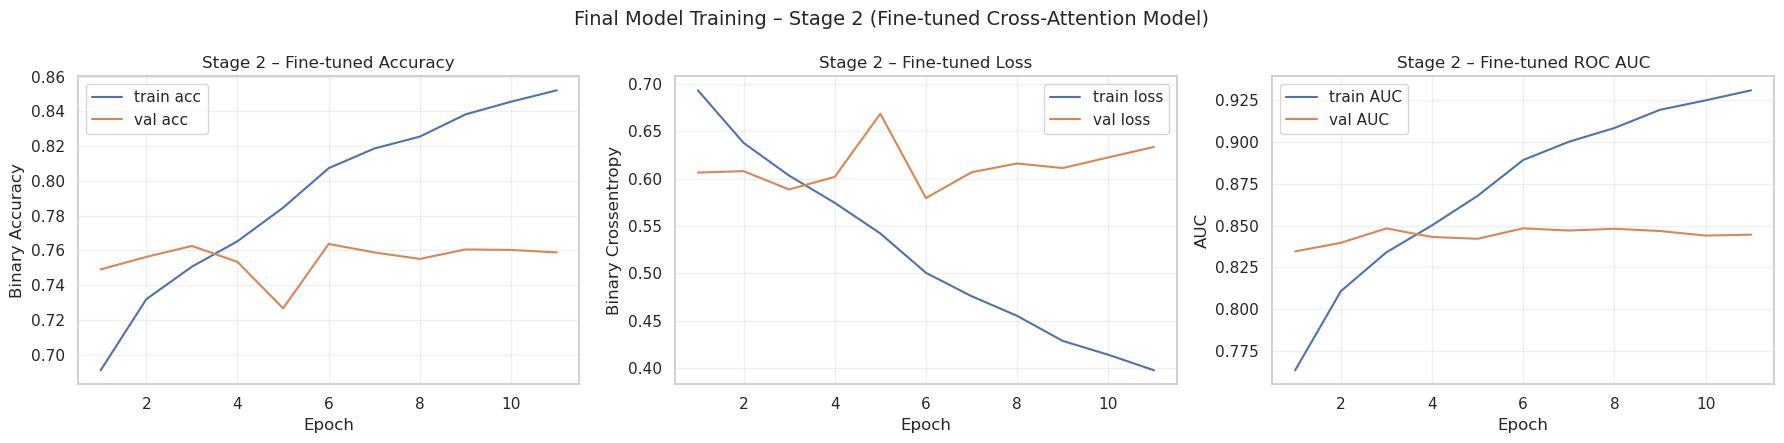

In [25]:
# Stage 2: unfreeze some EfficientNet + some BERT blocks; small LR
unfreeze_efficientnet_top(xatt_model, pct=0.35, freeze_bn=True)
unfreeze_bert_last_n_smart(xatt_model, n=2)

# ---------- Recompile for fine-tuning ----------
opt_xatt_2 = AdamW(learning_rate=5e-5, weight_decay=1e-5, clipnorm=1.0)
xatt_model.compile(optimizer=opt_xatt_2, loss="binary_crossentropy",
              metrics=common_metrics)

# ----- Stage 2 callbacks (NEW objects!) -----
cbs_s2_xatt = [
    ModelCheckpoint("artifacts/best_s2_xatt.keras", monitor="val_acc", mode="max", save_best_only=True),
    EarlyStopping(monitor="val_acc", mode="max", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.5, patience=2, cooldown=1, min_lr=2e-6),
]

print("\n--- Stage 1 completed, initiating Stage 2 ---\n")

hist2 = xatt_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=cbs_s2_xatt, verbose=1)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Convert Stage-2 history to DataFrame ---
hist_df = pd.DataFrame(hist2.history)
hist_df["epoch"] = np.arange(1, len(hist_df) + 1)

# --- Helper to safely get metrics (handles alias names) ---
def get_col(df, key):
    if key in df.columns:
        return df[key].values
    alt = {
        "acc": ["accuracy", "binary_accuracy"],
        "val_acc": ["val_accuracy", "val_binary_accuracy"],
        "auc": ["AUC", "roc_auc"],
        "val_auc": ["val_AUC", "val_roc_auc"],
    }
    for k in alt.get(key, []):
        if k in df.columns:
            return df[k].values
    raise KeyError(f"Metric '{key}' not found in columns: {list(df.columns)}")

# --- Plot Accuracy, Loss, and ROC-AUC ---
plt.figure(figsize=(18, 4.5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(hist_df["epoch"], get_col(hist_df, "acc"), label="train acc")
plt.plot(hist_df["epoch"], get_col(hist_df, "val_acc"), label="val acc")
plt.title("Stage 2 – Fine-tuned Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Binary Accuracy")
plt.grid(True, alpha=0.3); plt.legend()

# Loss
plt.subplot(1, 3, 2)
plt.plot(hist_df["epoch"], get_col(hist_df, "loss"), label="train loss")
plt.plot(hist_df["epoch"], get_col(hist_df, "val_loss"), label="val loss")
plt.title("Stage 2 – Fine-tuned Loss")
plt.xlabel("Epoch"); plt.ylabel("Binary Crossentropy")
plt.grid(True, alpha=0.3); plt.legend()

# ROC-AUC
plt.subplot(1, 3, 3)
plt.plot(hist_df["epoch"], get_col(hist_df, "auc"), label="train AUC")
plt.plot(hist_df["epoch"], get_col(hist_df, "val_auc"), label="val AUC")
plt.title("Stage 2 – Fine-tuned ROC AUC")
plt.xlabel("Epoch"); plt.ylabel("AUC")
plt.grid(True, alpha=0.3); plt.legend()

plt.suptitle("Final Model Training – Stage 2 (Fine-tuned Cross-Attention Model)", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
something wrong!

SyntaxError: invalid syntax (3942557818.py, line 1)

### Hyper parameter tunning 

In [ ]:

# ======================================================
# AdamW-based Random Search for Fine-Tuning Stage
# ======================================================
import os, random, numpy as np, joblib, gc, time, tensorflow as tf
from keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --------------------------
# Search space (refined)
# --------------------------
SEARCH_SPACE = {
    # Architecture
    "d_model":         [192, 256, 320],
    "num_heads":       [3, 4, 6, 8],
    "ffn_mult":        [2, 4],
    "num_xatt_blocks": [1, 2],
    "dropout":         [0.1, 0.2, 0.3],

    # Optimizer (Stage 1)
    "lr_stage1":       [1e-3, 5e-4],
    "wd_stage1":       [1e-4, 5e-5],

    # Optimizer (Stage 2)
    "lr_stage2":       [5e-5, 3e-5, 2e-5],
    "wd_stage2":       [1e-5, 5e-6],
    "clipnorm":        [1.0],

    # Unfreezing
    "unfreeze_pct":    [0.25, 0.35, 0.5],
    "bert_blocks":     [1, 2, 3],
}

def sample_cfg():
    return {k: random.choice(v) for k, v in SEARCH_SPACE.items()}

# --------------------------
# Metric helper
# --------------------------
def best_val_metric(h):
    """Return best validation accuracy or AUC from a history dict."""
    for key in ["val_acc", "val_binary_accuracy", "val_accuracy"]:
        if key in h:
            return max(h[key])
    for key in ["val_auc", "val_AUC", "val_roc_auc"]:
        if key in h:
            return max(h[key])
    return 0.0

# --------------------------
# Train one trial
# --------------------------
def train_one_trial(cfg, trial_id, epochs_stage1=8, epochs_stage2=8, seed=42):
    tf.keras.backend.clear_session()
    gc.collect()
    random.seed(seed + trial_id)
    np.random.seed(seed + trial_id)
    tf.random.set_seed(seed + trial_id)

    # --------------------------
    # Build model
    # --------------------------
    m = build_crossatt_bert_effnet(
        img_shape=(224, 224, 3),
        preset=PRESET,
        seq_len=SEQ_LEN,
        d_model=cfg["d_model"],
        num_heads=cfg["num_heads"],
        ffn_mult=cfg["ffn_mult"],
        num_xatt_blocks=cfg["num_xatt_blocks"],
        dropout=cfg["dropout"],
    )

    # ======================================================
    # Stage 1: frozen (baseline warm-up)
    # ======================================================
    opt1 = AdamW(
        learning_rate=cfg["lr_stage1"],
        weight_decay=cfg["wd_stage1"],
        clipnorm=cfg["clipnorm"]
    )
    m.compile(
        optimizer=opt1,
        loss="binary_crossentropy",
        metrics=common_metrics
    )

    cbs1 = [
        EarlyStopping(monitor="val_acc", mode="max", patience=3, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.5, patience=2, cooldown=1, min_lr=1e-6, verbose=0),
    ]

    hist1 = m.fit(train_ds, validation_data=val_ds,
                  epochs=epochs_stage1, callbacks=cbs1, verbose=0)

    # ======================================================
    # Stage 2: unfreeze + fine-tune
    # ======================================================
    unfreeze_efficientnet_top(m, pct=cfg["unfreeze_pct"], freeze_bn=True)
    unfreeze_bert_last_n_smart(m, n=cfg["bert_blocks"])

    opt2 = AdamW(
        learning_rate=cfg["lr_stage2"],
        weight_decay=cfg["wd_stage2"],
        clipnorm=cfg["clipnorm"]
    )
    m.compile(
        optimizer=opt2,
        loss="binary_crossentropy",
        metrics=common_metrics
    )

    cbs2 = [
        EarlyStopping(monitor="val_acc", mode="max", patience=4, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.5, patience=2, cooldown=1, min_lr=2e-6, verbose=0),
    ]

    hist2 = m.fit(train_ds, validation_data=val_ds,
                  epochs=epochs_stage2, callbacks=cbs2, verbose=0)

    # --------------------------
    # Evaluate best performance
    # --------------------------
    score1 = best_val_metric(hist1.history)
    score2 = best_val_metric(hist2.history)
    best_val = max(score1, score2)

    return m, best_val, {"hist1": hist1.history, "hist2": hist2.history}

# ======================================================
# Run random search
# ======================================================
os.makedirs("artifacts", exist_ok=True)
N_TRIALS = 8
EPOCHS_S1 = 6
EPOCHS_S2 = 8

best = {"score": -1, "cfg": None, "path": None}
t0 = time.time()

for t in range(1, N_TRIALS + 1):
    cfg = sample_cfg()
    model_t, score_t, hists = train_one_trial(cfg, t, epochs_stage1=EPOCHS_S1, epochs_stage2=EPOCHS_S2)
    print(f"[Trial {t:02d}] val_best={score_t:.4f} cfg={cfg}")

    if score_t > best["score"]:
        best["score"] = score_t
        best["cfg"] = cfg
        best_path = f"artifacts/best_crossatt_trial{t}.keras"
        model_t.save(best_path)
        best["path"] = best_path
        joblib.dump(hists, "artifacts/best_crossatt_hist.pkl")
        joblib.dump(cfg, "artifacts/best_crossatt_cfg.pkl")
        print(f"  New best model saved to {best_path}")

print(f"\nSearch completed in {time.time() - t0:.1f}s")
print("Best config:", best["cfg"])
print(f"Best validation metric: {best['score']:.4f}")
print(f"Saved model path:       {best['path']}")



2025-10-11 04:28:38.743548: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1760156934.531030   15219 service.cc:152] XLA service 0x55b5cef4b7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760156934.531057   15219 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-10-11 04:28:55.231742: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760156938.346815   15219 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760156959.779487   15219 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


EfficientNet: set trainable on top 50% (~119/238 layers). BN frozen=True
BERT: set trainable on last 1/4 transformer_layers
[Trial 01] val_best=0.7613 cfg={'d_model': 256, 'num_heads': 6, 'ffn_mult': 2, 'num_xatt_blocks': 1, 'dropout': 0.3, 'lr_stage1': 0.0005, 'wd_stage1': 0.0001, 'lr_stage2': 5e-05, 'wd_stage2': 1e-05, 'clipnorm': 1.0, 'unfreeze_pct': 0.5, 'bert_blocks': 1}
  New best model saved to artifacts/best_crossatt_trial1.keras
EfficientNet: set trainable on top 25% (~60/238 layers). BN frozen=True
BERT: set trainable on last 3/4 transformer_layers
[Trial 02] val_best=0.7717 cfg={'d_model': 256, 'num_heads': 6, 'ffn_mult': 4, 'num_xatt_blocks': 1, 'dropout': 0.3, 'lr_stage1': 0.001, 'wd_stage1': 0.0001, 'lr_stage2': 2e-05, 'wd_stage2': 1e-05, 'clipnorm': 1.0, 'unfreeze_pct': 0.25, 'bert_blocks': 3}
  New best model saved to artifacts/best_crossatt_trial2.keras
EfficientNet: set trainable on top 35% (~84/238 layers). BN frozen=True
BERT: set trainable on last 2/4 transformer_l

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'xatt_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### Training model with tunned hyper parameter

Best cfg: {'d_model': 256, 'num_heads': 6, 'ffn_mult': 4, 'num_xatt_blocks': 1, 'dropout': 0.3, 'lr_stage1': 0.001, 'wd_stage1': 0.0001, 'lr_stage2': 2e-05, 'wd_stage2': 1e-05, 'clipnorm': 1.0, 'unfreeze_pct': 0.25, 'bert_blocks': 3}
Epoch 1/100


2025-10-12 03:57:44.693959: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1760241479.672379   11618 service.cc:152] XLA service 0x55d6f0b2a590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760241479.672404   11618 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-10-12 03:58:00.377897: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760241483.090816   11618 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/990 ━━━━━━━━━━━━━━━━━━━━ 10:40:13 39s/step - acc: 0.5625 - auc: 0.4549 - loss: 1.2831

I0000 00:00:1760241502.988696   11618 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


990/990 ━━━━━━━━━━━━━━━━━━━━ 420s 385ms/step - acc: 0.4979 - auc: 0.4928 - loss: 0.9723 - val_acc: 0.4966 - val_auc: 0.5000 - val_loss: 0.7990 - learning_rate: 0.0010
Epoch 2/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 328s 331ms/step - acc: 0.4973 - auc: 0.4990 - loss: 0.7910 - val_acc: 0.5034 - val_auc: 0.5000 - val_loss: 0.7544 - learning_rate: 0.0010
Epoch 3/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 322s 325ms/step - acc: 0.5012 - auc: 0.5040 - loss: 0.7528 - val_acc: 0.5034 - val_auc: 0.5000 - val_loss: 0.7435 - learning_rate: 0.0010
Epoch 4/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 334s 337ms/step - acc: 0.5041 - auc: 0.5023 - loss: 0.7310 - val_acc: 0.5034 - val_auc: 0.5000 - val_loss: 0.7132 - learning_rate: 0.0010
Epoch 5/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 338s 341ms/step - acc: 0.4987 - auc: 0.4961 - loss: 0.7147 - val_acc: 0.5034 - val_auc: 0.5000 - val_loss: 0.7050 - learning_rate: 5.0000e-04
Epoch 6/100
990/990 ━━━━━━━━━━━━━━━━━━━━ 334s 337ms/step - acc: 0.4958 - auc: 0.4979 - loss: 0.7077 - val_acc: 0.

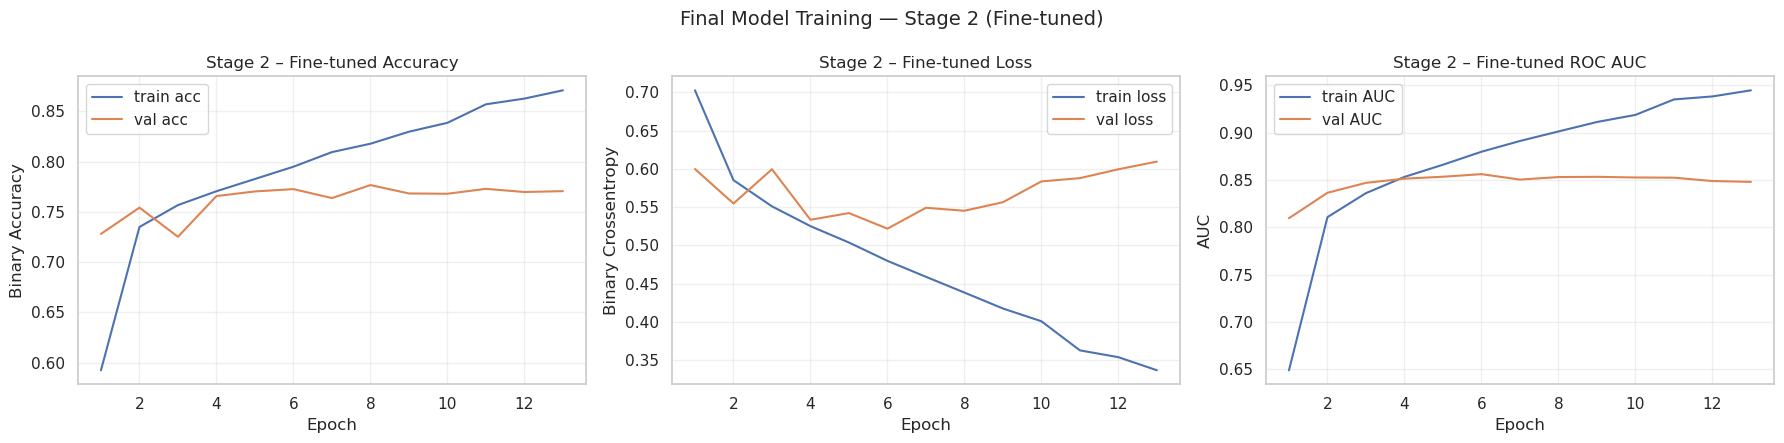

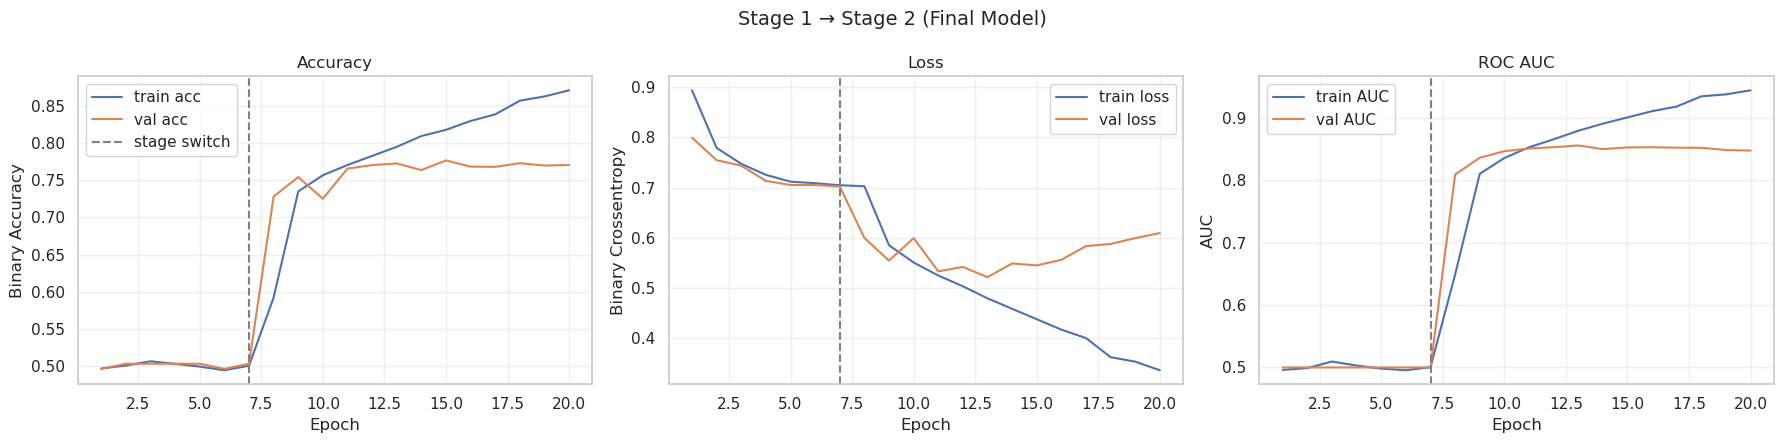

In [24]:
# ==============================
# 1) Load best config from search
# ==============================
import joblib, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import AdamW  

best_cfg = joblib.load("artifacts/best_crossatt_cfg.pkl")
print("Best cfg:", best_cfg)

final_ckpt_s1 = "artifacts/final_crossatt_s1.keras"  
final_ckpt_s2 = "artifacts/final_crossatt_s2.keras"  

# ==============================
# 2) Rebuild model with best cfg
# ==============================
final_model = build_crossatt_bert_effnet(
    img_shape=(224,224,3),
    preset=PRESET,
    seq_len=SEQ_LEN,
    d_model=best_cfg["d_model"],
    num_heads=best_cfg["num_heads"],
    ffn_mult=best_cfg["ffn_mult"],
    num_xatt_blocks=best_cfg["num_xatt_blocks"],
    dropout=best_cfg["dropout"],
)

# Metrics: use your common_metrics if available
metrics_final = common_metrics if "common_metrics" in globals() else [keras.metrics.BinaryAccuracy(name="acc")]  

# fresh callbacks (separate from search)
cbs_s1 = [
    keras.callbacks.ModelCheckpoint(final_ckpt_s1, monitor="val_acc", mode="max", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.5, patience=2, min_lr=1e-6),
]
cbs_s2 = [
    keras.callbacks.ModelCheckpoint(final_ckpt_s2, monitor="val_acc", mode="max", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.5, patience=2, min_lr=2e-6),
]

# ==============================
# 3) Train Stage 1 (frozen) then Stage 2 (fine-tune)
# ==============================
# --- Stage 1: frozen feature extraction ---
final_model.compile(
    optimizer=AdamW(learning_rate=best_cfg["lr_stage1"], weight_decay=best_cfg.get("wd_stage1", 1e-4)),  
    loss="binary_crossentropy",
    metrics=metrics_final,
)

hist1 = final_model.fit(
    train_ds, validation_data=val_ds,
    epochs=100, callbacks=cbs_s1, verbose=1
)

# Ensure we start Stage 2 from best Stage 1
try:
    final_model.load_weights(final_ckpt_s1)  # 
    print("[Stage 1] Loaded best S1 weights.")
except Exception as e:
    print(f"[Stage 1] Could not load best S1 weights: {e} (continuing with in-memory weights)")

# --- Stage 2: unfreeze + fine-tune ---
unfreeze_efficientnet_top(final_model, pct=best_cfg["unfreeze_pct"], freeze_bn=True)
unfreeze_bert_last_n_smart(final_model, n=best_cfg["bert_blocks"])

final_model.compile(
    optimizer=AdamW(learning_rate=best_cfg["lr_stage2"], weight_decay=best_cfg.get("wd_stage2", 1e-5)),  
    loss="binary_crossentropy",
    metrics=metrics_final,
)

hist2 = final_model.fit(
    train_ds, validation_data=val_ds,
    epochs=100, callbacks=cbs_s2, verbose=1
)

# Save histories
joblib.dump({"stage1": hist1.history, "stage2": hist2.history}, "artifacts/final_histories.pkl")

# ==============================
# 4) Plot training curves (Stage 2 only + merged optional)
# ==============================

def get_col(df, key):
    if key in df.columns:
        return df[key].values
    alt = {
        "acc": ["accuracy", "binary_accuracy"],
        "val_acc": ["val_accuracy", "val_binary_accuracy"],
        "auc": ["AUC", "roc_auc"],
        "val_auc": ["val_AUC", "val_roc_auc"],
    }
    for k in alt.get(key, []):
        if k in df.columns:
            return df[k].values
    raise KeyError(f"Metric '{key}' not found in columns: {list(df.columns)}")

# ---- Stage 2 only (your final model curves) ----  
hist2_df = pd.DataFrame(hist2.history)
hist2_df["epoch"] = np.arange(1, len(hist2_df) + 1)

plt.figure(figsize=(18, 4.5))
# Acc
plt.subplot(1,3,1)
plt.plot(hist2_df["epoch"], get_col(hist2_df, "acc"), label="train acc")
plt.plot(hist2_df["epoch"], get_col(hist2_df, "val_acc"), label="val acc")
plt.title("Stage 2 – Fine-tuned Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Binary Accuracy")
plt.grid(True, alpha=0.3); plt.legend()
# Loss
plt.subplot(1,3,2)
plt.plot(hist2_df["epoch"], get_col(hist2_df, "loss"), label="train loss")
plt.plot(hist2_df["epoch"], get_col(hist2_df, "val_loss"), label="val loss")
plt.title("Stage 2 – Fine-tuned Loss"); plt.xlabel("Epoch"); plt.ylabel("Binary Crossentropy")
plt.grid(True, alpha=0.3); plt.legend()
# AUC
plt.subplot(1,3,3)
try:
    plt.plot(hist2_df["epoch"], get_col(hist2_df, "auc"), label="train AUC")
    plt.plot(hist2_df["epoch"], get_col(hist2_df, "val_auc"), label="val AUC")
except KeyError:
    pass  # if AUC wasn't in metrics
plt.title("Stage 2 – Fine-tuned ROC AUC"); plt.xlabel("Epoch"); plt.ylabel("AUC")
plt.grid(True, alpha=0.3); plt.legend()
plt.suptitle("Final Model Training — Stage 2 (Fine-tuned)", fontsize=14)
plt.tight_layout(); plt.show()

# ---- (Optional) merged plot with switch marker ----
def merge_histories(h1, h2):
    df1 = pd.DataFrame(h1.history); df2 = pd.DataFrame(h2.history)
    df2.index = df2.index + len(df1)
    merged = pd.concat([df1, df2], axis=0)
    merged["epoch"] = np.arange(1, len(merged) + 1)
    return merged

hist_df = merge_histories(hist1, hist2)
switch_epoch = len(hist1.history.get("loss", []))

plt.figure(figsize=(18,4.5))
plt.subplot(1,3,1)
plt.plot(hist_df["epoch"], get_col(hist_df, "acc"), label="train acc")
plt.plot(hist_df["epoch"], get_col(hist_df, "val_acc"), label="val acc")
plt.axvline(switch_epoch, linestyle="--", color="gray", label="stage switch")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Binary Accuracy")
plt.grid(True, alpha=0.3); plt.legend()

plt.subplot(1,3,2)
plt.plot(hist_df["epoch"], get_col(hist_df, "loss"), label="train loss")
plt.plot(hist_df["epoch"], get_col(hist_df, "val_loss"), label="val loss")
plt.axvline(switch_epoch, linestyle="--", color="gray")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Binary Crossentropy")
plt.grid(True, alpha=0.3); plt.legend()

plt.subplot(1,3,3)
try:
    plt.plot(hist_df["epoch"], get_col(hist_df, "auc"), label="train AUC")
    plt.plot(hist_df["epoch"], get_col(hist_df, "val_auc"), label="val AUC")
except KeyError:
    pass
plt.axvline(switch_epoch, linestyle="--", color="gray")
plt.title("ROC AUC"); plt.xlabel("Epoch"); plt.ylabel("AUC")
plt.grid(True, alpha=0.3); plt.legend()

plt.suptitle("Stage 1 → Stage 2 (Final Model)", fontsize=14)
plt.tight_layout(); plt.show()


### Observation
- 

### Final Evaluation on Hold out Test data

Final evaluation of the model performance has been done on the hold out test data, the data that model has never seen before. Tough we have position our thesis with a measuremtn matrics as accuracy however in the final evaluation we have checked other parameter as well that includes confusion matrix, to know how many of the data point model is predicting accurately and how many are actually wrong, we have printed the overall classification report as well. 

Loading best model from: artifacts/final_crossatt_s2.keras


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'xatt_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 116 variables whereas the saved optimizer has 212 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - acc: 0.7633 - auc: 0.8437 - loss: 0.5668
TEST metrics: {'loss': 0.5464118719100952, 'compile_metrics': 0.7710539698600769}


2025-10-12 06:40:39.570097: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step
TEST ROC-AUC: 0.8524
TEST PR-AUC : 0.8540

Classification report:
              precision    recall  f1-score   support

           0     0.7665    0.7735    0.7700      1965
           1     0.7756    0.7686    0.7721      2001

    accuracy                         0.7711      3966
   macro avg     0.7711    0.7711    0.7710      3966
weighted avg     0.7711    0.7711    0.7711      3966



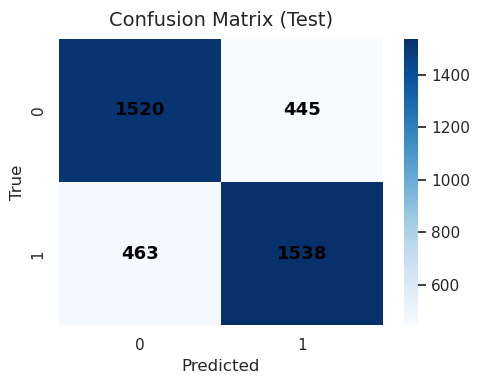

In [32]:
# ==============================
# 5) Final evaluation on TEST (once!)
# ==============================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import tensorflow as tf
from tensorflow import keras
import os

# Make sure test ds is built without shuffling
test_ds = make_ds_bert(test_df, training=False, batch=32)

# 1) Prefer Stage-2 (fine-tuned) checkpoint; fall back if not found
ckpt_candidates = [
    globals().get("final_ckpt_s2", None),
    globals().get("final_ckpt_s1", None),
    globals().get("final_ckpt", None),
]
ckpt_candidates = [c for c in ckpt_candidates if c]

model_path = next((c for c in ckpt_candidates if os.path.exists(c)), None)
if model_path is None:
    raise FileNotFoundError("No final checkpoint found. Expected one of final_ckpt_s2 / final_ckpt_s1 / final_ckpt.")

print(f"Loading best model from: {model_path}")
# (Optional) free old graphs/weights
tf.keras.backend.clear_session()

best_final = keras.models.load_model(
    model_path,
    custom_objects={"CrossAttentionBlock": CrossAttentionBlock},
    compile=True,  # uses saved optimizer/metrics if present
)

# 2) Evaluate with compiled metrics
test_metrics = best_final.evaluate(test_ds, verbose=1)
print("TEST metrics:", dict(zip(best_final.metrics_names, test_metrics)))

# 3) Collect y_true robustly
y_true = []
for batch in test_ds:
    # Expect (x, y)
    if isinstance(batch, (tuple, list)) and len(batch) == 2:
        _, yb = batch
    else:
        raise ValueError("Unexpected dataset structure; expected (x, y) per batch.")
    y_true.append(np.array(yb).reshape(-1))  # works for (B,1) or (B,)

y_true = np.concatenate(y_true, axis=0).astype(int)

# 4) Predict probabilities
y_prob = best_final.predict(test_ds, verbose=1)
# Handle shapes: (N,1) -> (N,)
if y_prob.ndim == 2 and y_prob.shape[1] == 1:
    y_prob = y_prob[:, 0]
elif y_prob.ndim > 1:
    # If model outputs logits for two classes (softmax), take p(class 1)
    if y_prob.shape[1] == 2:
        y_prob = y_prob[:, 1]
    else:
        raise ValueError(f"Unexpected prediction shape: {y_prob.shape}")

# 5) Hard predictions @ 0.5
y_pred = (y_prob >= 0.5).astype(int)

# 6) Additional report metrics
try:
    roc = roc_auc_score(y_true, y_prob)
    pr  = average_precision_score(y_true, y_prob)
    print(f"TEST ROC-AUC: {roc:.4f}")
    print(f"TEST PR-AUC : {pr:.4f}")
except Exception as e:
    print(f"Skipping AUC metrics: {e}")

print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))

# 7) Confusion matrix plot (cleaner)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",          # light blue color map for readability
    cbar=True,
    annot_kws={"size": 13, "weight": "bold", "color": "black"}
)
plt.title("Confusion Matrix (Test)", fontsize=14, pad=10)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.tight_layout()
plt.show()

### Observation
- The model has overall accuracy of 0.77, which is better then the baseline accuracy
- The confusion matrics says it is able to classify 1520 class, that are predicted contradiction and actually they are contradiction
- About the entailment 1538 are being predicted entailment and actually is entailement - however, 445 of them is being predicted entailment but actually is contradiction, on the other hand 463 of the test sample is being predicted contradiction but actually is entailment.
- If we look at both of the number that are misclassified, there are 463 test sample that are being predicted as contradiction, but the number of the other side which is 445 predicted as entailement but actually is contradiction is bit less. Which leads us, the model is probably confused more about contradiction. Coming up we will analyse why model is behaving in this way.

## Posthoc-Error Analysis of Model (xAI- Answering the why question)

In this section, we dig into why the model misclassifies some samples—for example, predicting contradiction as entailment or vice versa. Although neural networks are often viewed as black boxes, we use Explainable AI (XAI) tools to peek inside and interpret their behavior. Specifically, we have applied Grad-CAM to visualize which image regions the vision branch relies on, SHAP to reveal which words in the hypothesis push the decision toward or away from the contradiction class, and a cross-attention heat map to show where the text (CLS token) attends over image patches during fusion. Together, these view will help us see whether the model is focusing on the right visual evidence, attributing weight to the right words, and aligning text–image cues correctly.

### Loading our best model
We have loaded our final model, and also created the test ds with training false which ensures the images are not poisoned with any process such as shuffling, this will ensure our numbering is stable so that we can target specific image for analyze and it remains stable on each run.

In [85]:
best_cfg = joblib.load("artifacts/best_crossatt_cfg.pkl")
print("Best cfg:", best_cfg)

# Rebuild architecture exactly as before 
model_xai = build_crossatt_bert_effnet(
    img_shape=(224,224,3),
    preset=PRESET,          
    seq_len=SEQ_LEN,
    d_model=best_cfg["d_model"],
    num_heads=best_cfg["num_heads"],
    ffn_mult=best_cfg["ffn_mult"],
    num_xatt_blocks=best_cfg["num_xatt_blocks"],
    dropout=best_cfg["dropout"],
)


model_xai = keras.models.load_model(
    model_path,  # your final_crossatt_s2.keras
    custom_objects={"CrossAttentionBlock": CrossAttentionBlock},
    compile=False,
)

# test ds without shuffling
test_ds = make_ds_bert(test_df, training=False, batch=32)

Best cfg: {'d_model': 256, 'num_heads': 6, 'ffn_mult': 4, 'num_xatt_blocks': 1, 'dropout': 0.3, 'lr_stage1': 0.001, 'wd_stage1': 0.0001, 'lr_stage2': 2e-05, 'wd_stage2': 1e-05, 'clipnorm': 1.0, 'unfreeze_pct': 0.25, 'bert_blocks': 3}


### Defining test samples 
In this block we have defined the test sample, we have taken 6 samples that the model predicted wrong and 6 samples that the model has predicted right, so that we can differentiate model behaviour with two question, 1. if model is predicting wrong then why it is doing that , 2. If model is predicting right then why it is predicting right. To make the analysis easier we have tagged the image with respected row id 

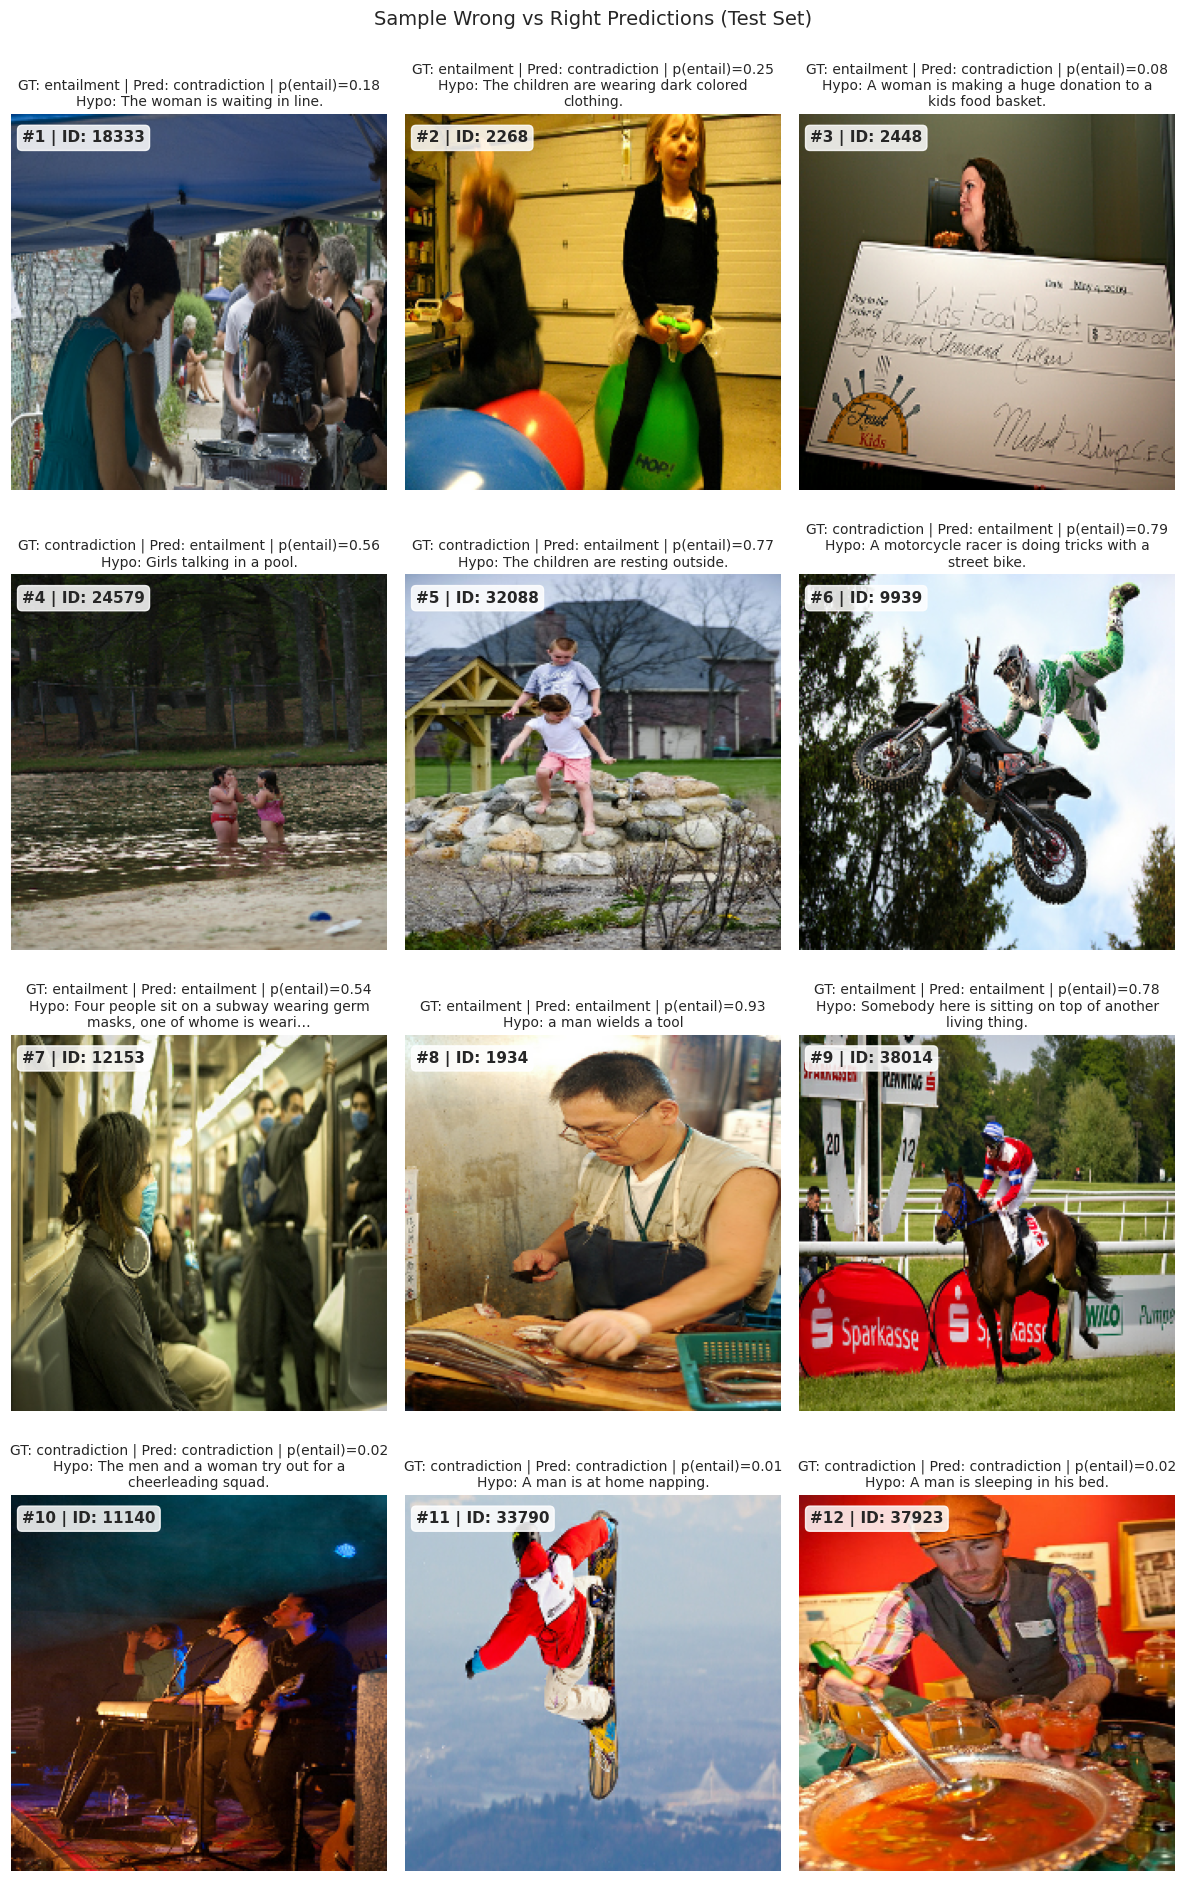

In [86]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, textwrap, tensorflow as tf
os.environ["PYTHONHASHSEED"]="0"
random.seed(42); np.random.seed(42); tf.random.set_seed(42)

# GT = Ground Truth

LABELS = {0: "contradiction", 1: "entailment"}  # adjust if yours differ

# Get predictions for test set
y_true = test_df["y"].values.astype(int)
probs  = best_final.predict(test_ds, verbose=0).squeeze()
if probs.ndim > 1:
    probs = probs[:, 1]

y_pred = (probs >= 0.5).astype(int)

# Attach to a copy of test_df for easy filtering + FREEZE a stable row_id
df = test_df.reset_index().rename(columns={"index": "row_id"}).copy()
df["prob1"]   = probs
df["y_pred"]  = y_pred
df["correct"] = (df["y_pred"] == df["y"])

# Buckets
FN = df[(df["y"] == 1) & (df["y_pred"] == 0)]  # entailment → predicted contradiction
FP = df[(df["y"] == 0) & (df["y_pred"] == 1)]  # contradiction → predicted entailment
TP = df[(df["y"] == 1) & (df["y_pred"] == 1)]
TN = df[(df["y"] == 0) & (df["y_pred"] == 0)]

# Pick 6 sample from wrong prediction and right prediction
k_wrong   = 6
k_correct = 6
pick_df = pd.concat([
    FN.sample(min(len(FN), k_wrong//2), random_state=42),
    FP.sample(min(len(FP), k_wrong - min(len(FN), k_wrong//2)), random_state=42),
    TP.sample(min(len(TP), k_correct//2), random_state=42),
    TN.sample(min(len(TN), k_correct - min(len(TP), k_correct//2)), random_state=42),
], ignore_index=False)

# Keeping a ref map (panel number -> row_id), handy for later analysis
ref_map = pick_df[["row_id","path","y","y_pred","prob1","hypo"]].reset_index(drop=True)
# ref_map.to_csv("xai_sample_ref_map.csv", index=False)   

# 5) Helpers
def truncate(s, n=70):
    s = str(s)
    return s if len(s) <= n else s[:n-1] + "…"

def load_img(path):
    # Use your existing decode_image
    return decode_image(path).numpy()  # (H,W,3) float32 in [0..1]

# Plot grid (with panel numbering + ID badge)
n = len(ref_map)
cols = 3
rows = int(np.ceil(n / cols))
plt.figure(figsize=(4*cols, 4.8*rows))

for i, r in enumerate(pick_df.itertuples(index=False), start=1):
    plt.subplot(rows, cols, i)
    img = load_img(r.path)
    plt.imshow(img); plt.axis("off")

    # Corner badge: panel number + row_id
    plt.text(
        6, 16, f"#{i} | ID: {r.row_id}",
        fontsize=11, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85)
    )

    gt   = LABELS[int(r.y)]
    pr   = LABELS[int(r.y_pred)]
    p1   = float(r.prob1)
    hypo = truncate(getattr(r, "hypo", ""))

    title_top = f"GT: {gt} | Pred: {pr} | p(entail)={p1:.2f}"
    title_bot = f"Hypo: {hypo}"
    title = title_top + "\n" + "\n".join(textwrap.wrap(title_bot, width=48))
    plt.title(title, fontsize=10)

plt.suptitle("Sample Wrong vs Right Predictions (Test Set)", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# helper to explain by stable ID later
# def explain_by_row_id(row_id):
#     # Find current index of this row_id (robust even if df is re-ordered later)
#     i = df.index[df["row_id"] == row_id][0]
#     return explain_idx(int(i))


### Observation
- 

In [87]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap

# ----------------------------------------
# CONFIG
# ----------------------------------------
LABELS = {0: "contradiction", 1: "entailment"}  
SEQ_LEN = 32
IMG_SIZE = (224, 224)

# ----------------------------------------
# STABLE-ID EVAL DF
# ----------------------------------------

EVAL_DF = None

def ensure_eval_df():
    """Create a stable eval DataFrame with 'row_id' if not already set."""
    global EVAL_DF
    if EVAL_DF is None:
        if "row_id" in test_df.columns:
            EVAL_DF = test_df.copy()
        else:
            EVAL_DF = test_df.reset_index().rename(columns={"index": "row_id"}).copy()
    return EVAL_DF

# ----------------------------------------
# HELPERS
# ----------------------------------------
def pack_text_with_keras_hub(raw_texts):
    """Tokenize text using your keras_hub preprocessor."""
    out = preproc(raw_texts)
    seg_key = "segment_ids" if "segment_ids" in out else ("token_type_ids" if "token_type_ids" in out else None)
    token_ids    = out["token_ids"].numpy().astype(np.int32)
    padding_mask = out["padding_mask"].numpy().astype(bool)
    segment_ids  = out[seg_key].numpy().astype(np.int32) if seg_key else np.zeros_like(token_ids, dtype=np.int32)
    return token_ids, segment_ids, padding_mask

def _p1_from_out(out):
    """Return class-1 prob for either sigmoid [N]/[N,1] or softmax [N,2]."""
    out = np.array(out)
    if out.ndim == 1:      # [N]
        return out
    if out.shape[-1] == 1: # [N,1]
        return out.squeeze(-1)
    if out.shape[-1] == 2: # [N,2]
        return out[:, 1]
    raise ValueError(f"Unexpected output shape: {out.shape}")

def build_inputs_for_row(row):
    """Build a single test sample as model input."""
    img = decode_image(row["path"])                         # (H,W,3)
    img = tf.expand_dims(img, 0)                            # (1,H,W,3)
    tok, seg, mask = pack_text_with_keras_hub([row["hypo"]])
    inputs = [
        img,                                   # image float32
        tf.convert_to_tensor(mask, tf.bool),   # padding_mask bool
        tf.convert_to_tensor(seg,  tf.int32),  # segment_ids int32
        tf.convert_to_tensor(tok,  tf.int32),  # token_ids int32
    ]
    return inputs, img[0].numpy()

def gradcam_image_only(model, image_batched, layer_name="block7a_project_conv", alpha=0.45):
    """Simple Grad-CAM for the EfficientNet branch."""
    img_backbone = None
    for l in model.layers:
        if "efficientnet" in l.name:
            img_backbone = l
            break
    if img_backbone is None:
        raise ValueError("EfficientNet backbone not found in model.")
    last_conv = img_backbone.get_layer(layer_name)
    gradcam_model = tf.keras.Model(inputs=img_backbone.input, outputs=[last_conv.output, img_backbone.output])

    with tf.GradientTape() as tape:
        conv_out, preds = gradcam_model(image_batched, training=False)
        target = tf.reduce_mean(preds)

    grads = tape.gradient(target, conv_out)
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    cam = tf.reduce_sum(weights * conv_out, axis=-1)  # (1,H,W)
    cam = tf.nn.relu(cam)[0].numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam_resized = tf.image.resize(cam[..., None], IMG_SIZE).numpy()[..., 0]
    return cam_resized

# ----------------------------------------
# MAIN EXPLAINERS
# ----------------------------------------
def explain_idx(idx, layer_name="block7a_project_conv", thresh=0.5):
    """Explain one test sample: prediction + GradCAM + SHAP (index-based)."""
    row = test_df.iloc[idx]
    sample_inputs, img_np = build_inputs_for_row(row)

    # --- Prediction ---
    out  = best_final.predict(sample_inputs, verbose=0)
    p1   = float(_p1_from_out(out).squeeze())
    y_pred = int(p1 >= thresh)
    y_true = int(row["y"])
    print(f"\nidx={idx}")
    print(f"path: {row['path']}")
    print(f"text: {row['hypo']}")
    print(f"True : {LABELS.get(y_true, y_true)} ({y_true})")
    print(f"Pred : {LABELS.get(y_pred, y_pred)} ({y_pred})  | p1={p1:.4f}")

    # --- Grad-CAM (image) ---
    cam = gradcam_image_only(best_final, sample_inputs[0], layer_name=layer_name)
    plt.figure(figsize=(5,5))
    plt.imshow(np.clip(img_np, 0, 1))
    plt.imshow(cam, cmap="jet", alpha=0.45)
    plt.axis("off")
    plt.title("Grad-CAM (image encoder)")
    plt.tight_layout()
    plt.show()

    # --- SHAP (text) ---
    def predict_text_only(texts):
        tok, seg, mask = pack_text_with_keras_hub(texts)
        B = len(texts)
        inputs = [
            np.repeat(sample_inputs[0].numpy(), B, axis=0).astype(np.float32),  # fixed image
            mask.astype(bool),
            seg.astype(np.int32),
            tok.astype(np.int32),
        ]
        out = best_final.predict(inputs, verbose=0)
        return _p1_from_out(out)

    # Cache the text explainer across calls for speed (module-global)
    global _TEXT_EXPLAINER
    try:
        _TEXT_EXPLAINER
    except NameError:
        _TEXT_EXPLAINER = None

    if _TEXT_EXPLAINER is None:
        masker = shap.maskers.Text()
        _TEXT_EXPLAINER = shap.Explainer(predict_text_only, masker)
        _ = _TEXT_EXPLAINER(["neutral background text.", "simple description."])  # warmup

    sv = _TEXT_EXPLAINER([row["hypo"]])
    shap.plots.text(sv[0])

def explain_by_row_id(row_id, **kwargs):
    """
    Explain a sample by its stable row_id.
    Usage: explain_by_row_id(123, layer_name="block7a_project_conv", thresh=0.5)
    """
    df = ensure_eval_df()
    # locate current positional index of this row_id
    matches = df.index[df["row_id"] == row_id]
    if len(matches) == 0:
        raise KeyError(f"row_id {row_id} not found. Make sure you created the gallery from the same split.")
    idx = int(matches[0])
    return explain_idx(idx, **kwargs)

def explain_many_by_id(row_ids, **kwargs):
    """Convenience: loop over a list of IDs."""
    for rid in row_ids:
        explain_by_row_id(int(rid), **kwargs)

# ----------------------------------------
# Usage
# ----------------------------------------
# Explain by ID:
# explain_by_row_id(0)                 # if gallery showed ID: 0
# explain_by_row_id(123, thresh=0.45)  # custom threshold
# explain_many_by_id([7, 42, 105])


In [88]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, math


def _pos_idx_from_row_id(row_id):
    df = ensure_eval_df()
    hits = df.index[df["row_id"] == row_id]
    if len(hits) == 0:
        raise KeyError(f"row_id {row_id} not found in current test_df")
    return int(hits[0])

# ---------------------------
# CROSS-ATTENTION Heatmap
# ---------------------------
def xatt_by_row_id(row_id, block_index=-1, title="Cross-attention (CLS → image patches)"):
    """
    Visualize cross-attention for a sample by stable row_id.
    - model_xai must contain CrossAttentionBlock layers that cache `.last_attn`
      as shape (B, heads, T_q, T_k). We take mean over heads, assume T_q=1.
    - block_index: which CrossAttentionBlock to read (default last = -1).
    """
    df = ensure_eval_df()
    idx = _pos_idx_from_row_id(row_id)
    row = df.iloc[idx]

    # Build inputs (fixed image + its text)
    sample_inputs, img_np, raw_text = _build_inputs_for_row(row)

    # Forward pass to populate attention cache in the chosen block
    _ = model_xai(sample_inputs, training=False)

    # Find cross-attention blocks
    xatt_layers = [l for l in model_xai.layers if isinstance(l, CrossAttentionBlock)]
    if not xatt_layers:
        raise RuntimeError("No CrossAttentionBlock found in model_xai.")
    # Pick block
    xatt = xatt_layers[block_index]

    # Grab cached attention (B, heads, T_q, T_k)
    scores = xatt.last_attn
    if scores is None:
        raise RuntimeError("Attention scores not cached; ensure CrossAttentionBlock sets .last_attn inside call().")

    # Average over heads → (T_q, T_k). Assume single query token (CLS), so take [0]
    attn = tf.reduce_mean(scores[0], axis=0)[0]  # (T_k,)
    P = int(attn.shape[0])
    g = int(round(math.sqrt(P)))                 # infer grid size (e.g., 7x7)
    if g * g != P:
        # Fallback: try to guess nearest square; otherwise just reshape with best guess
        g = int(np.floor(np.sqrt(P)))
        if g * g != P:
            raise ValueError(f"Cannot reshape attention of length {P} into a square grid.")

    attn_map = tf.reshape(attn, (g, g)).numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() + 1e-8)
    attn_up  = tf.image.resize(attn_map[..., None], img_np.shape[:2]).numpy()[..., 0]

    # Plot overlay
    plt.figure(figsize=(5,5))
    plt.imshow(np.clip(img_np, 0, 1))
    plt.imshow(attn_up, cmap="jet", alpha=0.45)
    plt.axis("off")
    plt.title(f"{title}\nID: {row_id} | block_index={block_index}")
    plt.tight_layout()
    plt.show()

def xatt_many_by_id(row_ids, block_index=-1):
    """Run the cross-attention visualizer for multiple IDs."""
    for rid in row_ids:
        xatt_by_row_id(int(rid), block_index=block_index)

# ---------------------------
# USAGE
# ---------------------------
# ensure_eval_df()               # optional once per session
# xatt_by_row_id(123)            # visualize for ID=123 (last cross-attention block)
# xatt_by_row_id(123, block_index=0)   # visualize the first cross-attention block
# xatt_many_by_id([7, 42, 105], block_index=-1)


2025-10-13 09:12:51.916450: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}



idx=2499
path: A2_Images/2949880800.jpg
text: Girls talking in a pool.
True : contradiction (0)
Pred : entailment (1)  | p1=0.5626


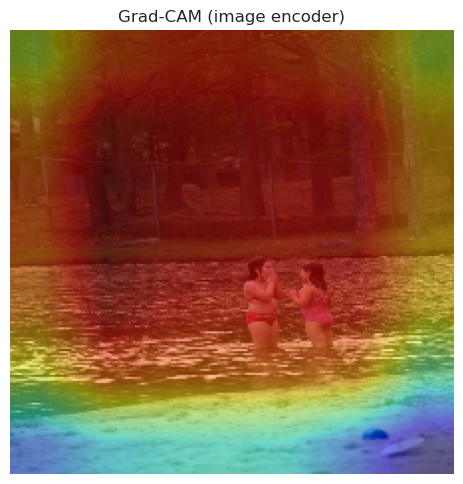

In [89]:
explain_by_row_id(24579)  

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: {'image': 'image', 'token_ids': 'token_ids', 'segment_ids': 'segment_ids', 'padding_mask': 'padding_mask'}. Received: the structure of inputs=['*', '*', '*', '*']
  warnings.warn(


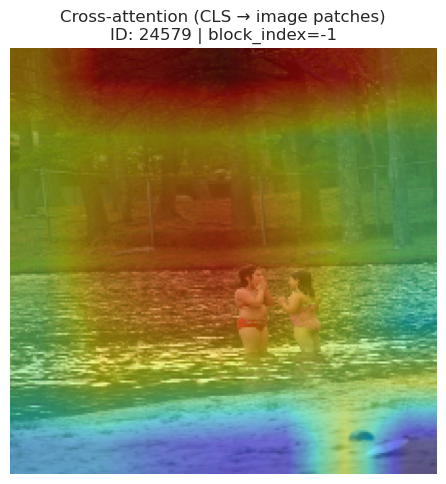

In [90]:
xatt_by_row_id(24579)  

### Observation
- 